# Interesting Maps

In [10]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from qiskit.circuit.random import random_circuit
from qiskit.providers.aer import QasmSimulator

from src import *
%matplotlib inline
#np.set_printoptions(threshold=sys.maxsize)

## Generating Kraus Maps from Highly Structured Unitary Matrices

In [2]:
def generate_random_circuit_unitary(d, rank, depth, verbose = False): 
    backend = QasmSimulator()
    backend_options = {'method': 'statevector'}
    
    n_eff = int(np.log2(d*rank))
    random_circ = random_circuit(n_eff, depth)
    
    U = np.zeros((rank*d, d), dtype="complex128")
    if verbose:
        dec = tqdm
    else:
        dec = lambda x: x
    
    for i in dec(range(d)):
        prep = qk.QuantumCircuit(n_eff)
        flip_list = numberToBase(i, 2, n_eff)
        for j, flip in enumerate(reversed(flip_list)):
            if flip: prep.x(j)
            
        slice_circuit = prep.compose(random_circ)
        slice_circuit.save_statevector()
        
        job = qk.execute(slice_circuit, backend, backend_options=backend_options)
        U_slice = job.result().get_statevector(slice_circuit).data
        U[:,i] = U_slice
    
    return U

def layer(circuit, n, idx):
    if idx%2 == 0:
        
        for i in range(n):
            theta = np.random.uniform(0, 2*np.pi)
            circuit.ry(theta, i)
            
        for i in range(n//2):
            theta = np.random.uniform(0, 2*np.pi)
            circuit.cx(2*i, 2*i+1)
    else:
        
        for i in range(n):
            theta = np.random.uniform(0, 2*np.pi)
            circuit.rz(theta, i)
            
        for i in range(n//2-1+n%2):
            theta = np.random.uniform(0, 2*np.pi)
            circuit.cx(2*i+1, 2*(i+1))
    
    return circuit


def haar_layer(circuit, n, idx):
    if idx%2 == 0:
        for i in range(n//2):
            random_pair = random_unitary(4)
            circuit.compose(random_pair, [2*i, 2*i+1])   
    else:      
        for i in range(n//2-1+n%2):
            random_pair = random_unitary(4)
            circuit.compose(random_pair, [2*i+1, 2*(i+1)])
    
    return circuit
            

def generate_random_variational_unitary(d, rank, depth, verbose = False): 
    backend = QasmSimulator()
    backend_options = {'method': 'statevector'}
    
    n_eff = int(np.log2(d*rank))
    random_circ = qk.QuantumCircuit(n_eff)
    for i in range(depth):
        random_circ = haar_layer(random_circ, n_eff, i)

    U = np.zeros((rank*d, d), dtype="complex128")
    if verbose:
        dec = tqdm
    else:
        dec = lambda x: x
    
    for i in dec(range(d)):
        prep = qk.QuantumCircuit(n_eff)
        flip_list = numberToBase(i, 2, n_eff)
        for j, flip in enumerate(reversed(flip_list)):
            if flip: prep.x(j)
            
        slice_circuit = prep.compose(random_circ)
        slice_circuit.save_statevector()
        
        job = qk.execute(slice_circuit, backend, backend_options=backend_options)
        U_slice = job.result().get_statevector(slice_circuit).data
        U[:,i] = U_slice
    
    return U


t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

### Linear Depth

  0%|          | 0/1000 [00:00<?, ?it/s]

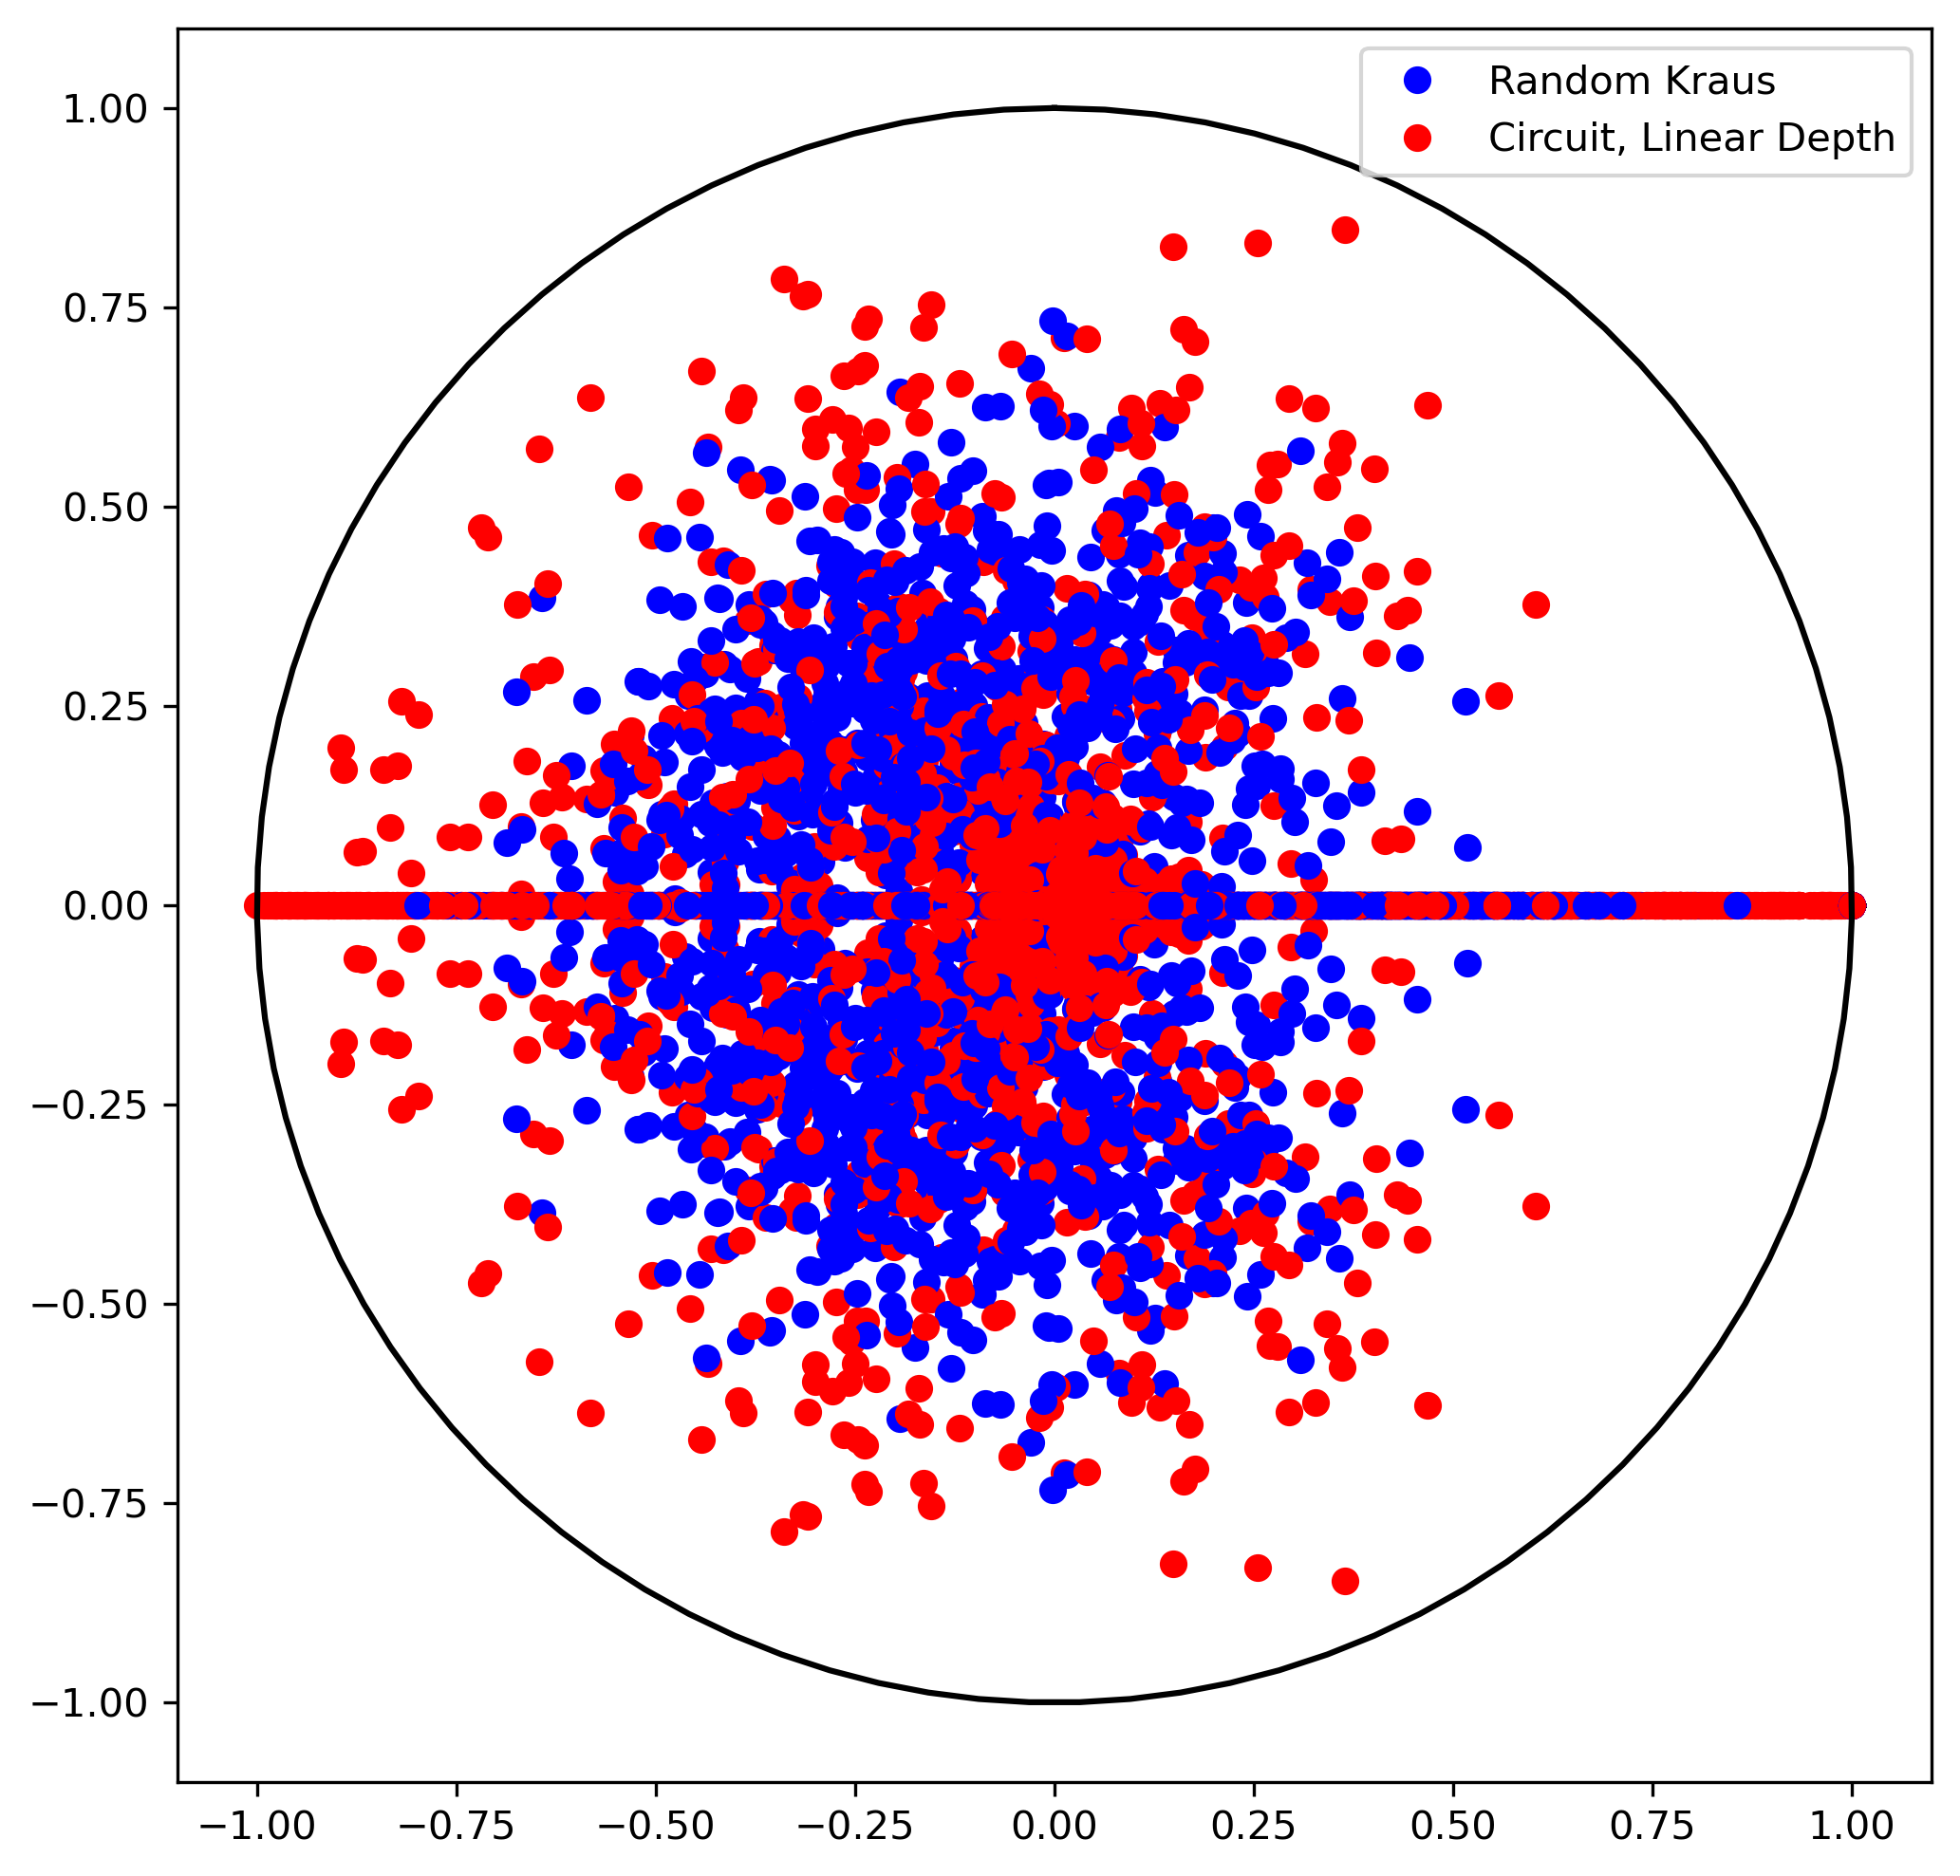

In [3]:
n = 1
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(1000)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    
    plt.plot(*spectrum1, "bo")
    plt.plot(*spectrum2, "ro")

plt.legend(["Random Kraus", "Circuit, Linear Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/oneQubit_linearDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

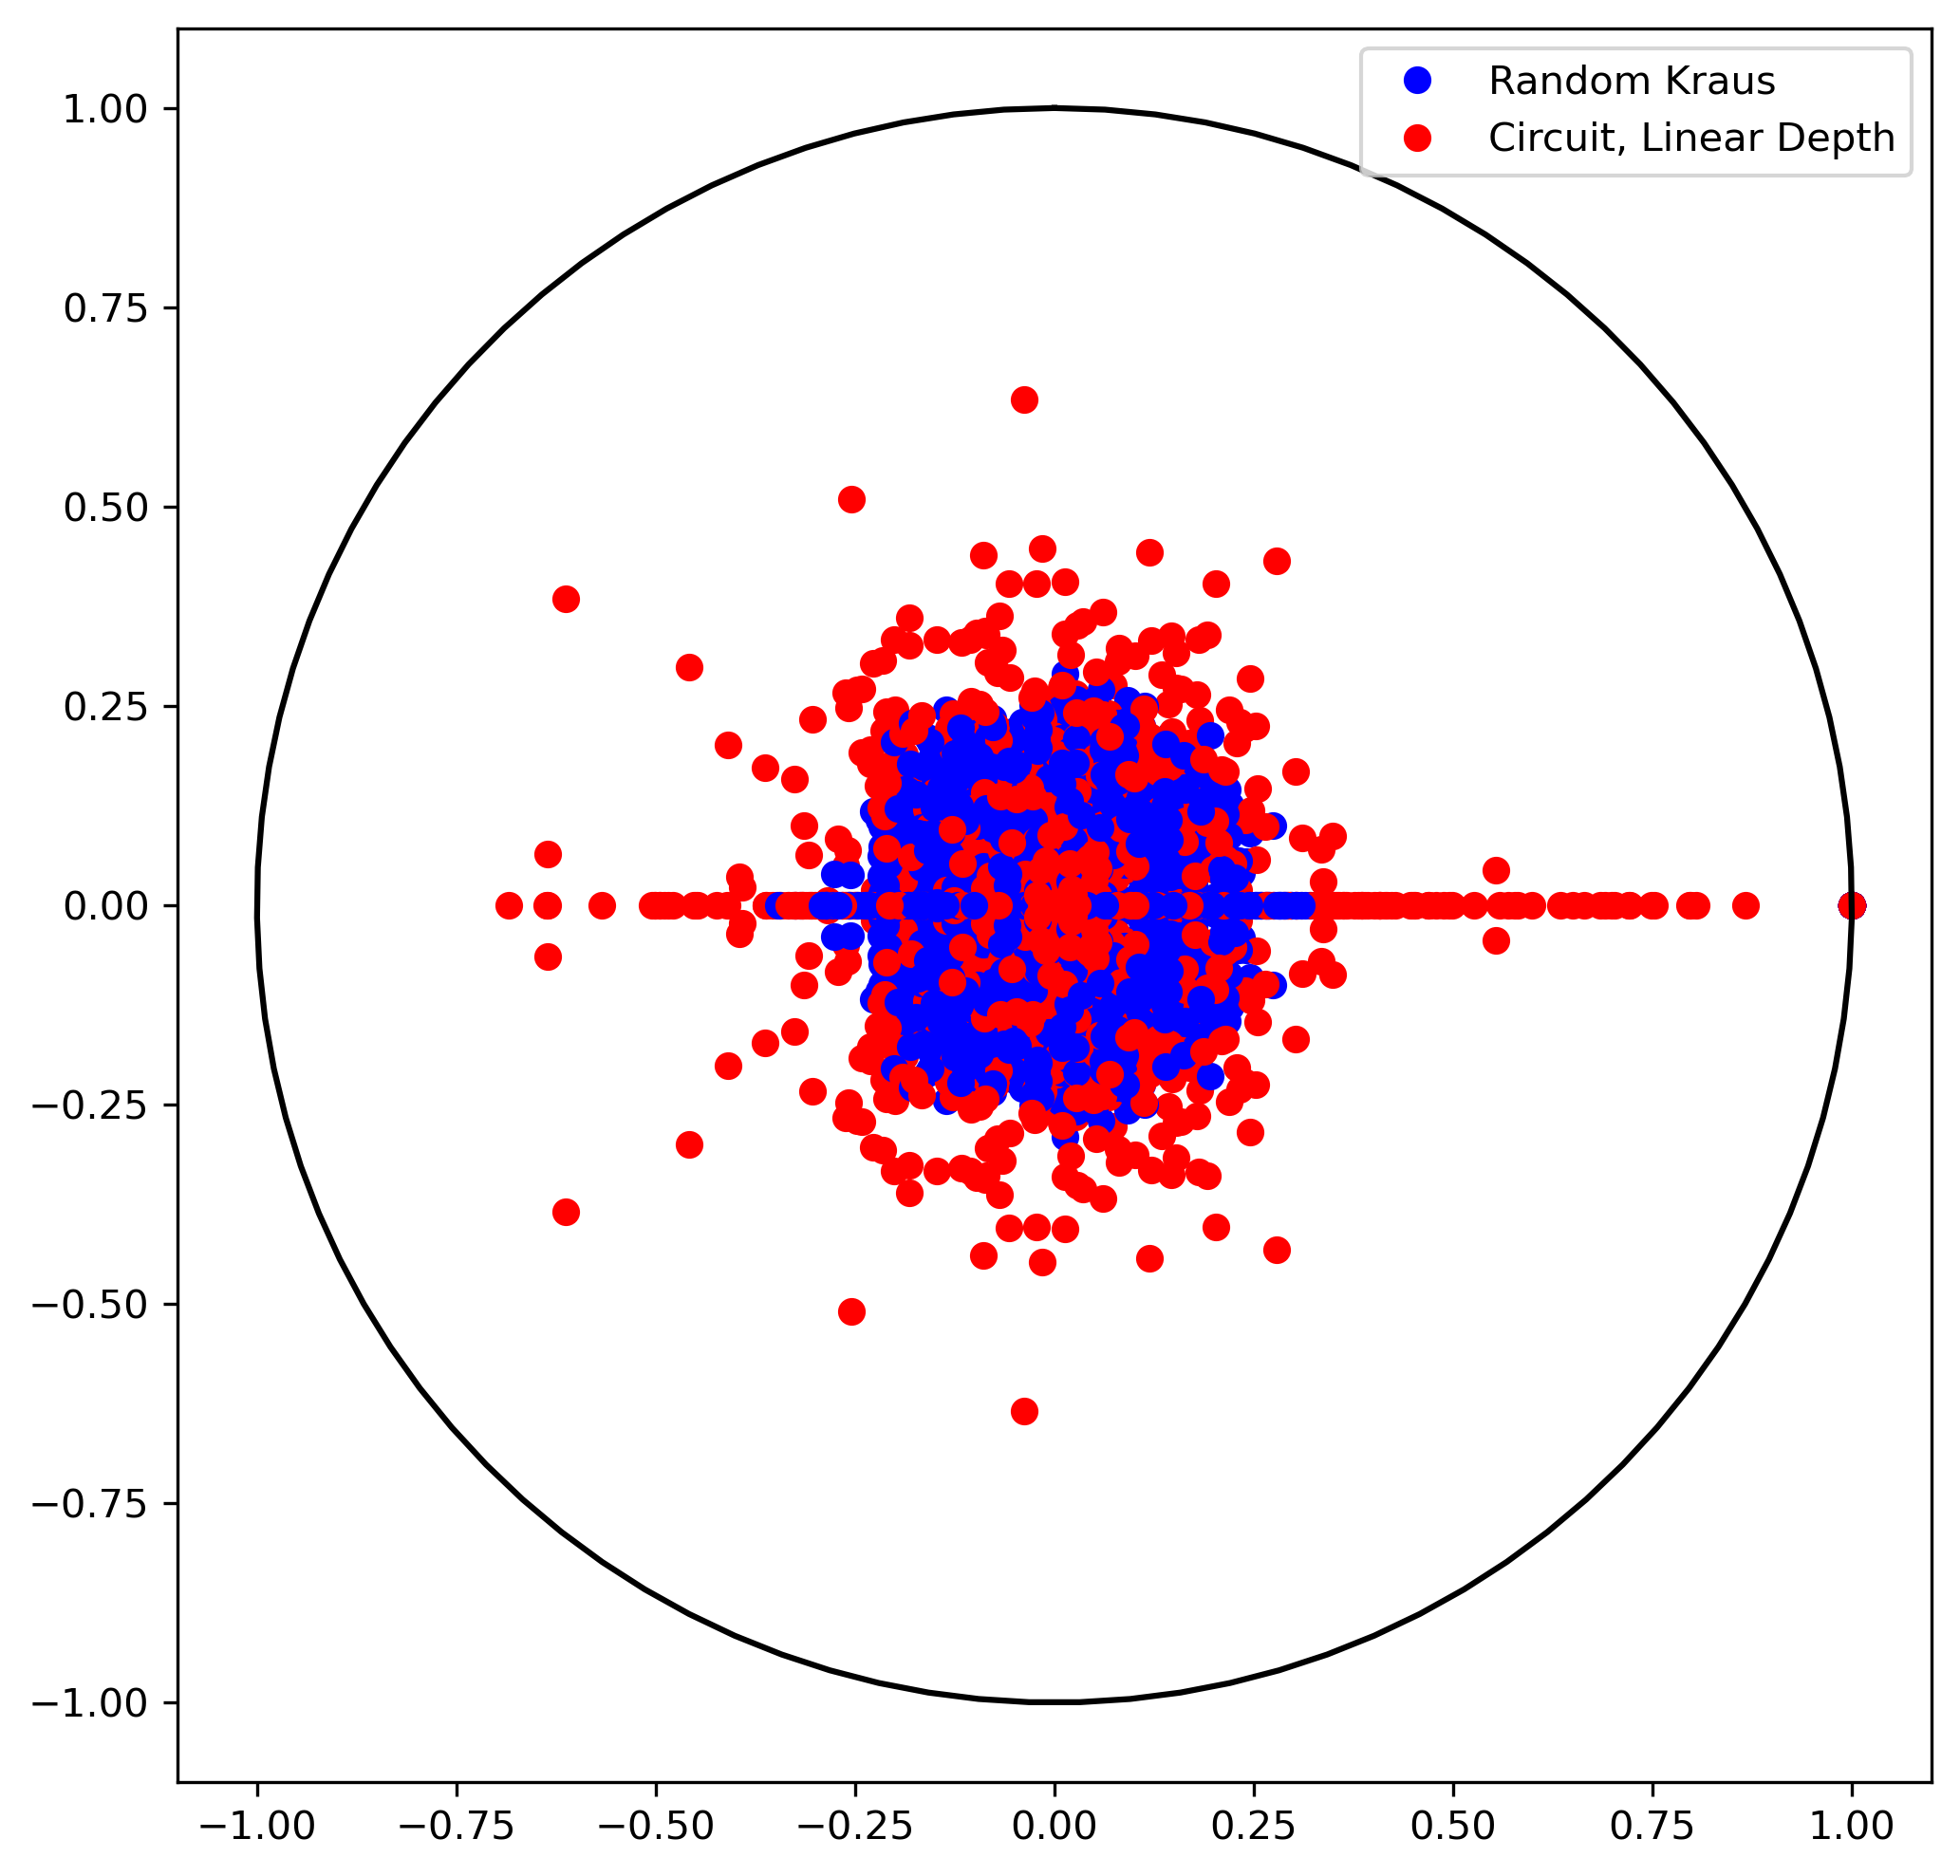

In [4]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum1, "bo")
    plt.plot(*spectrum2, "ro")

plt.legend(["Random Kraus", "Circuit, Linear Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/twoQubit_linearDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

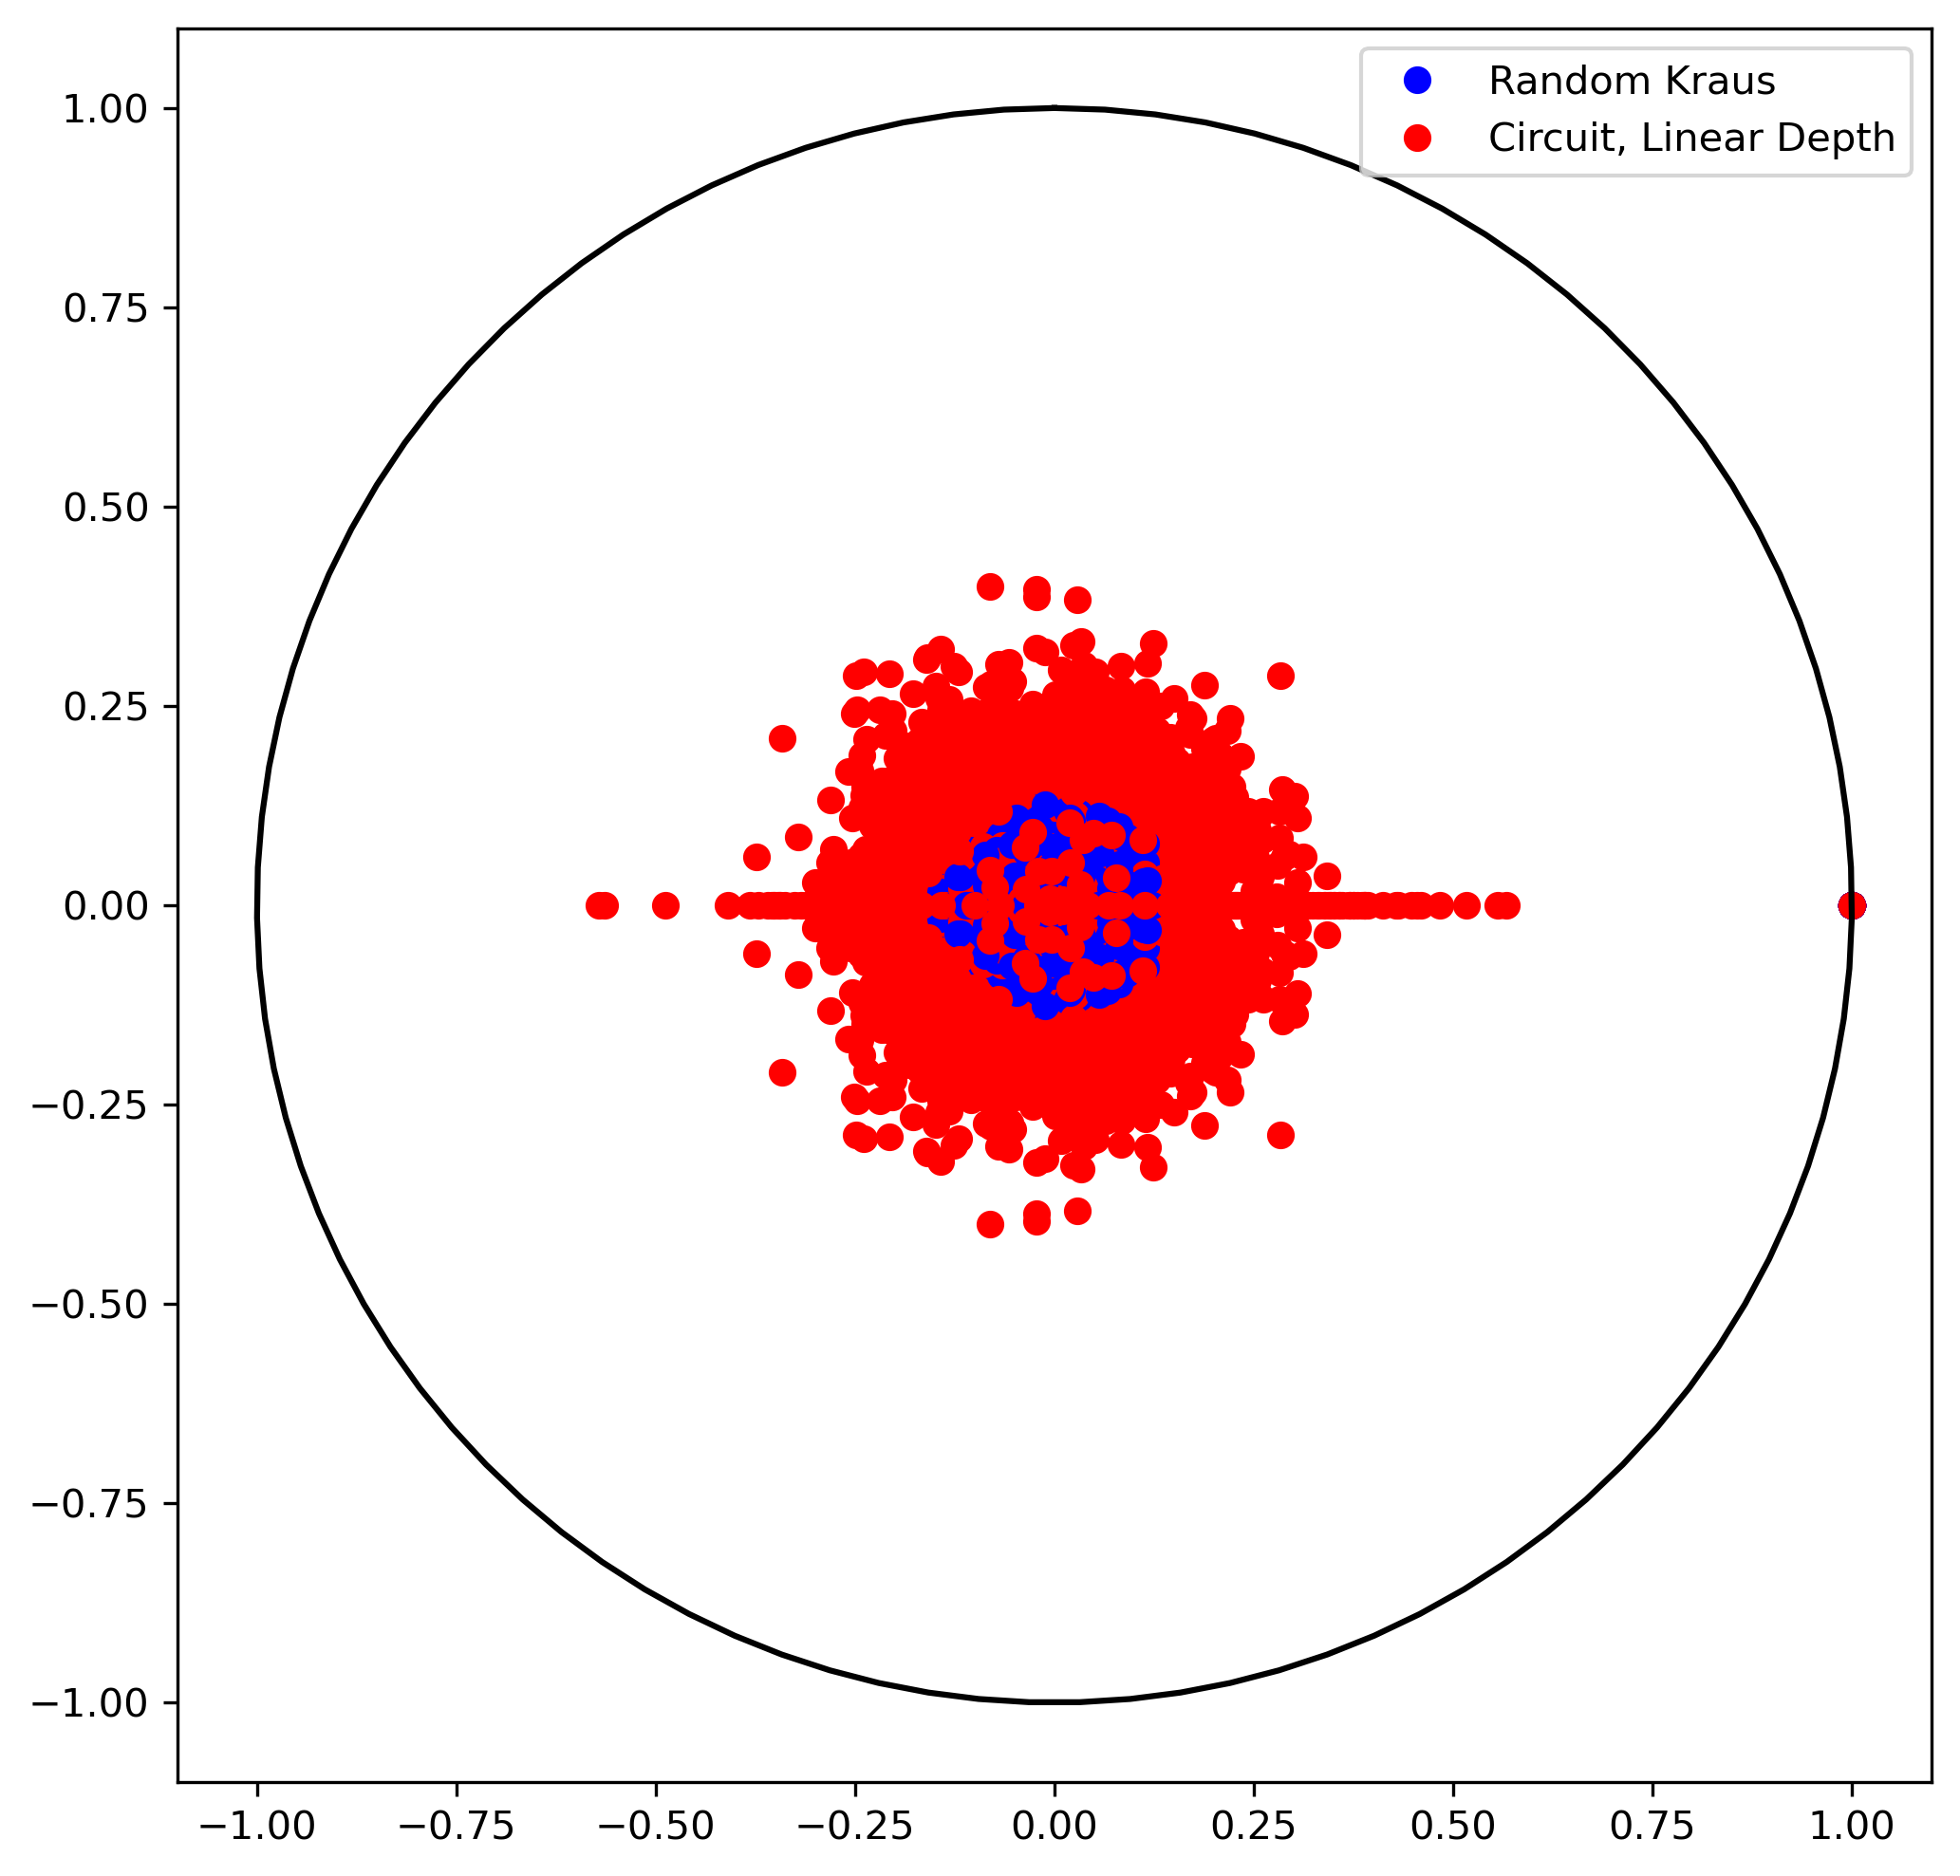

In [5]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    
    plt.plot(*spectrum1, "bo")
    plt.plot(*spectrum2, "ro")

plt.legend(["Random Kraus", "Circuit, Linear Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/threeQubit_linearDepth.pdf")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

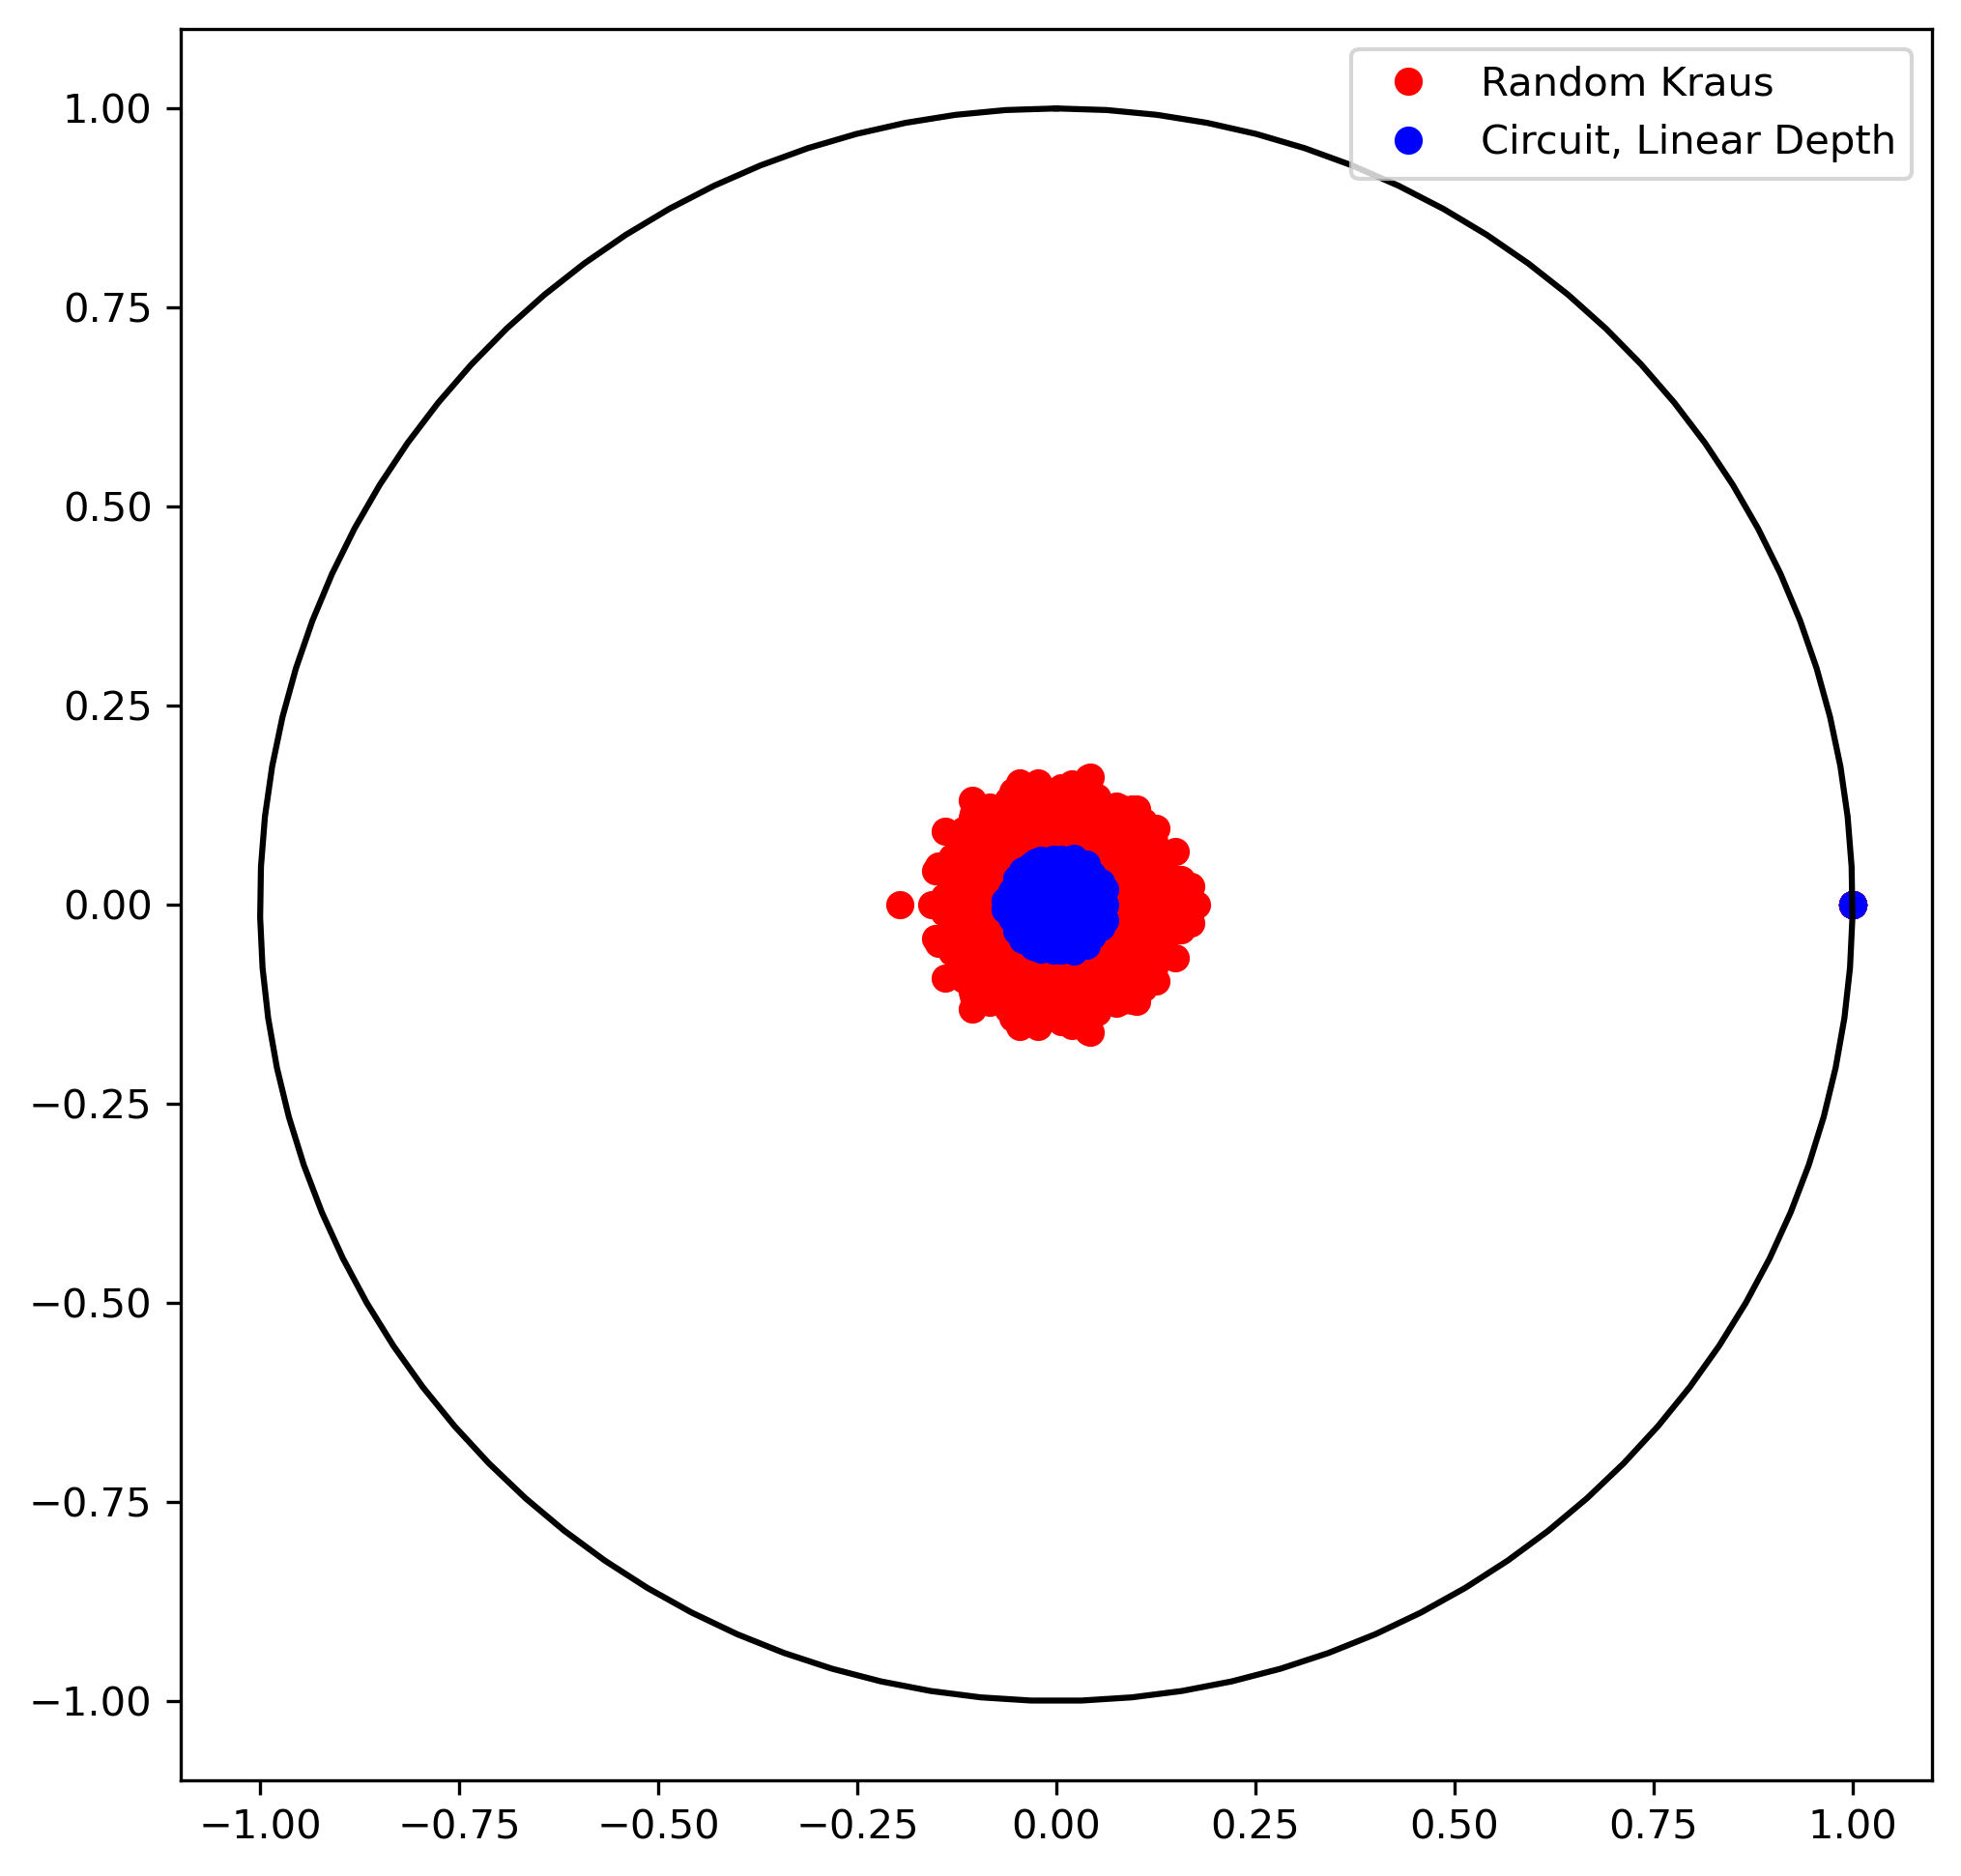

In [11]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(10)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    
    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")
    

plt.legend(["Random Kraus", "Circuit, Linear Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fourQubit_linearDepth.pdf")
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

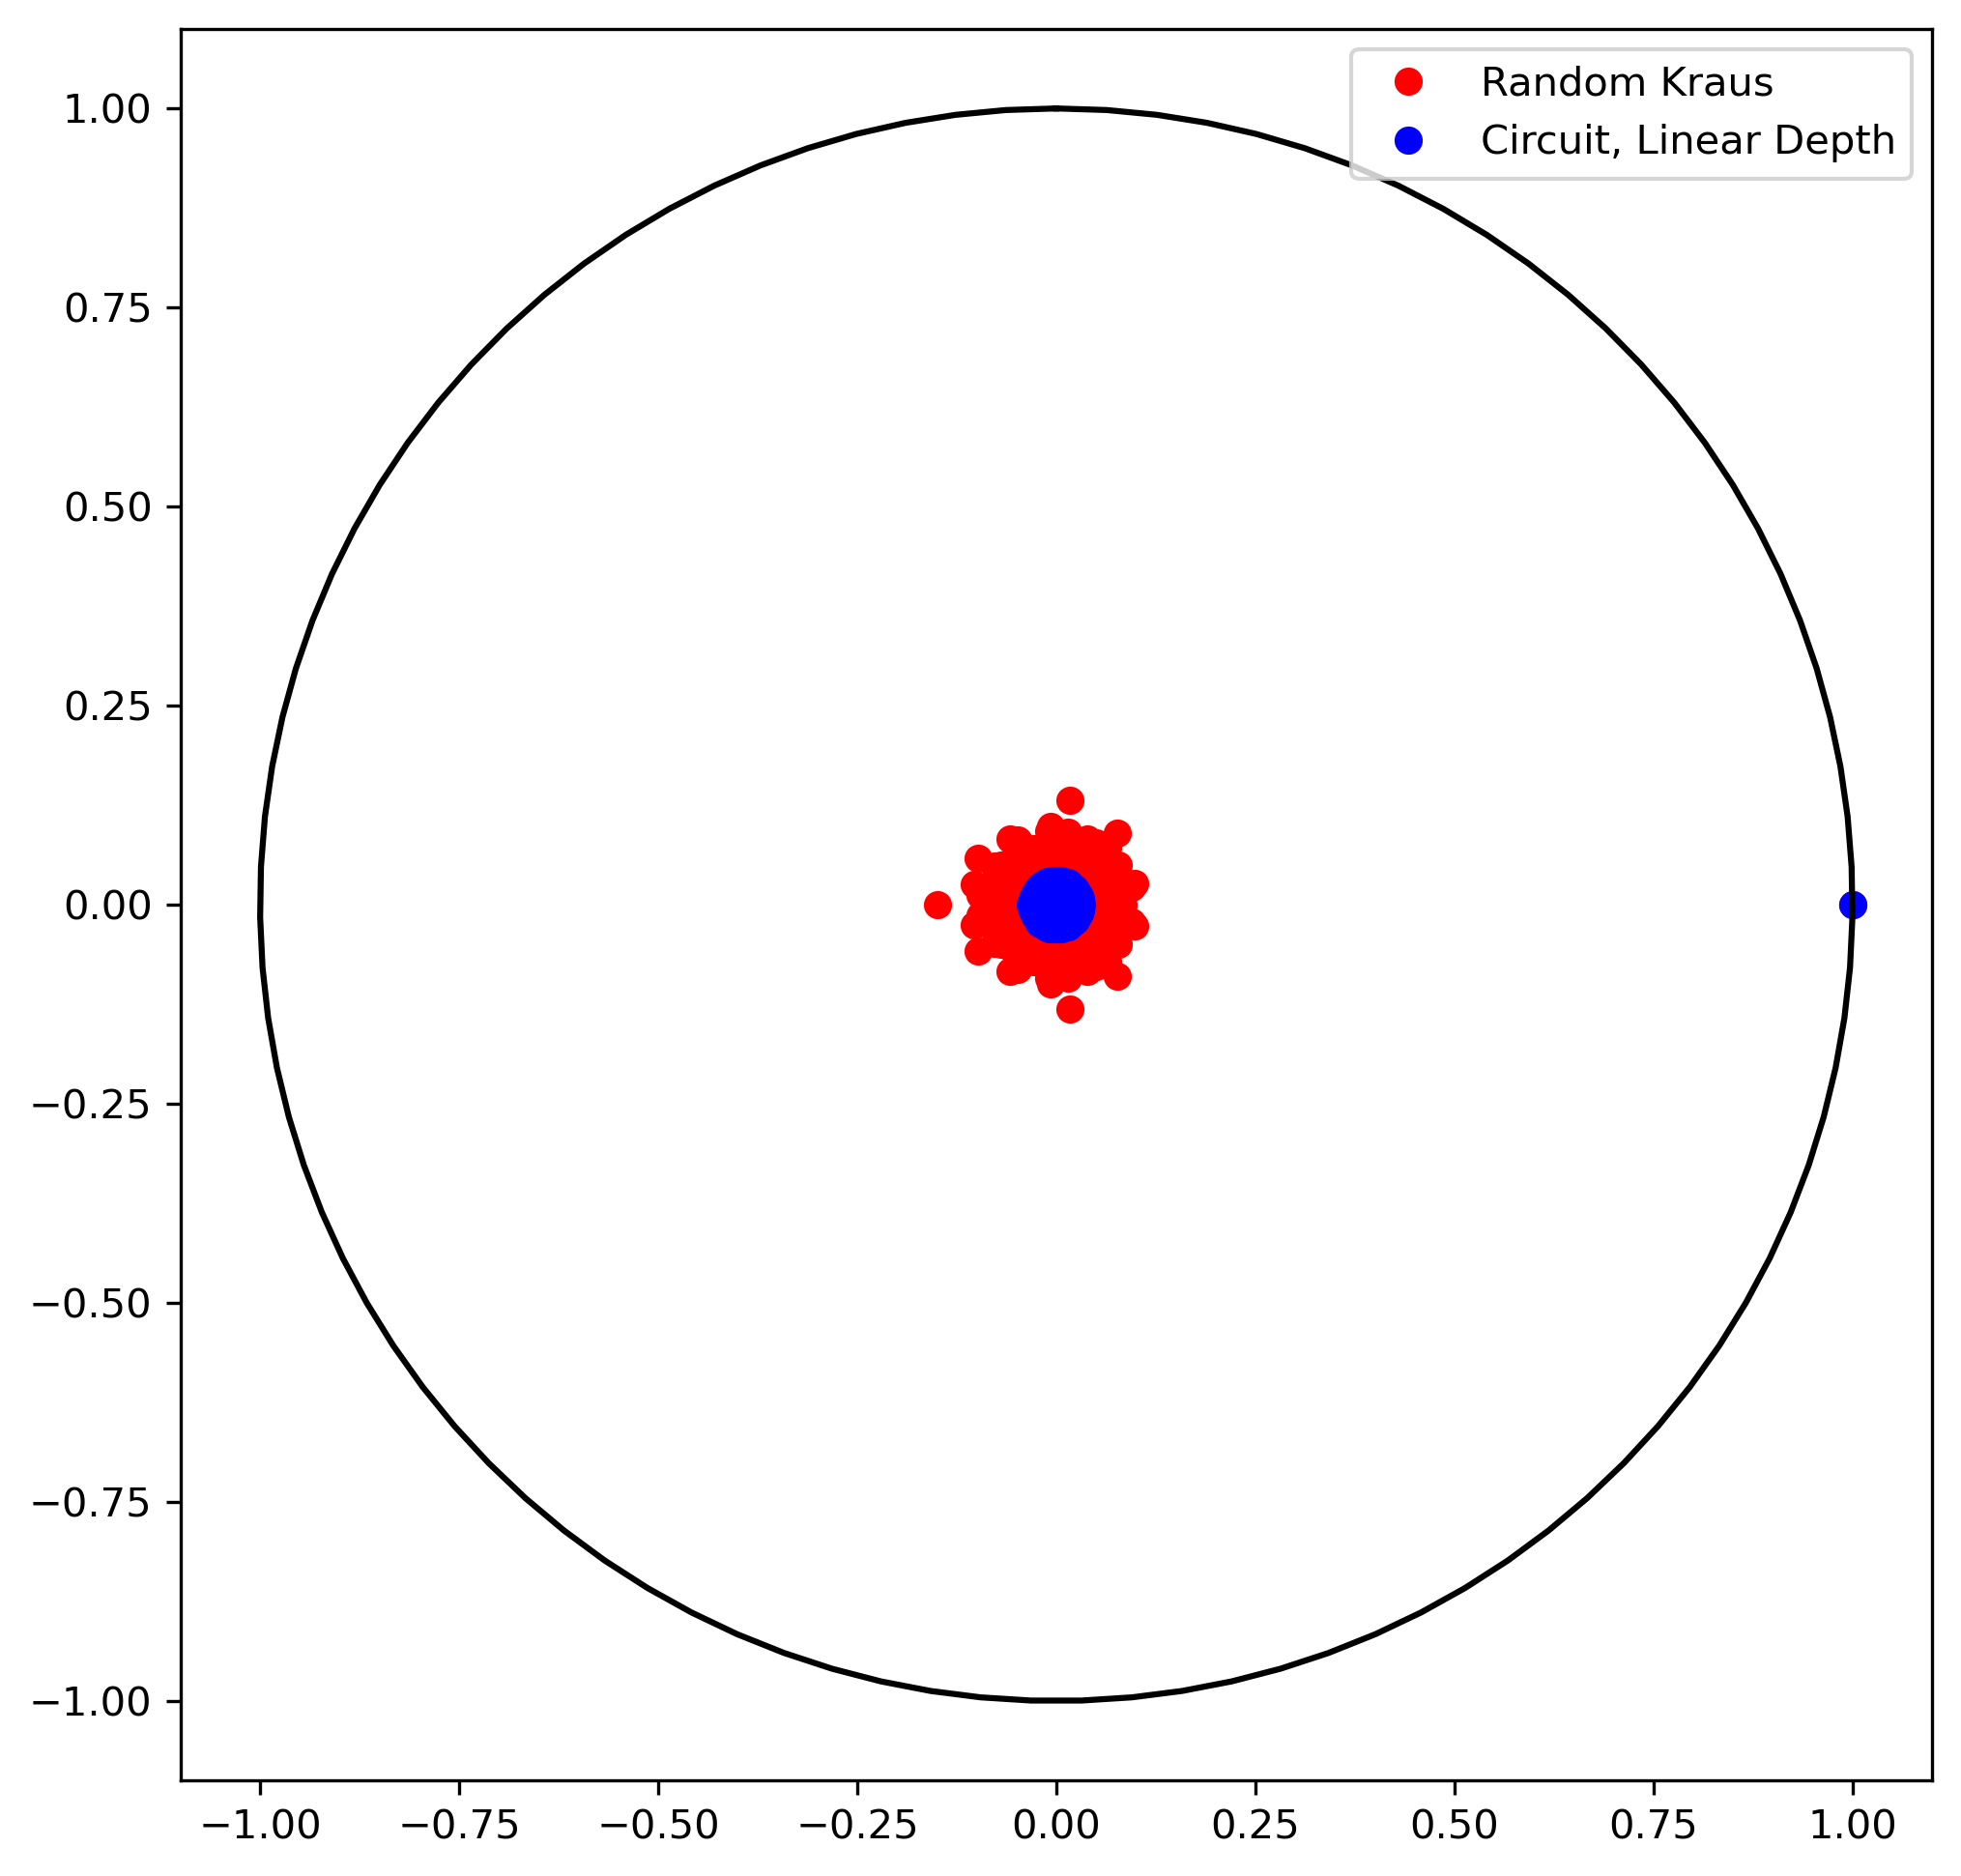

In [12]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(1)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)
    
    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")
    

plt.legend(["Random Kraus", "Circuit, Linear Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fiveQubit_linearDepth.pdf")
plt.show()

### Square Depth

  0%|          | 0/1000 [00:00<?, ?it/s]

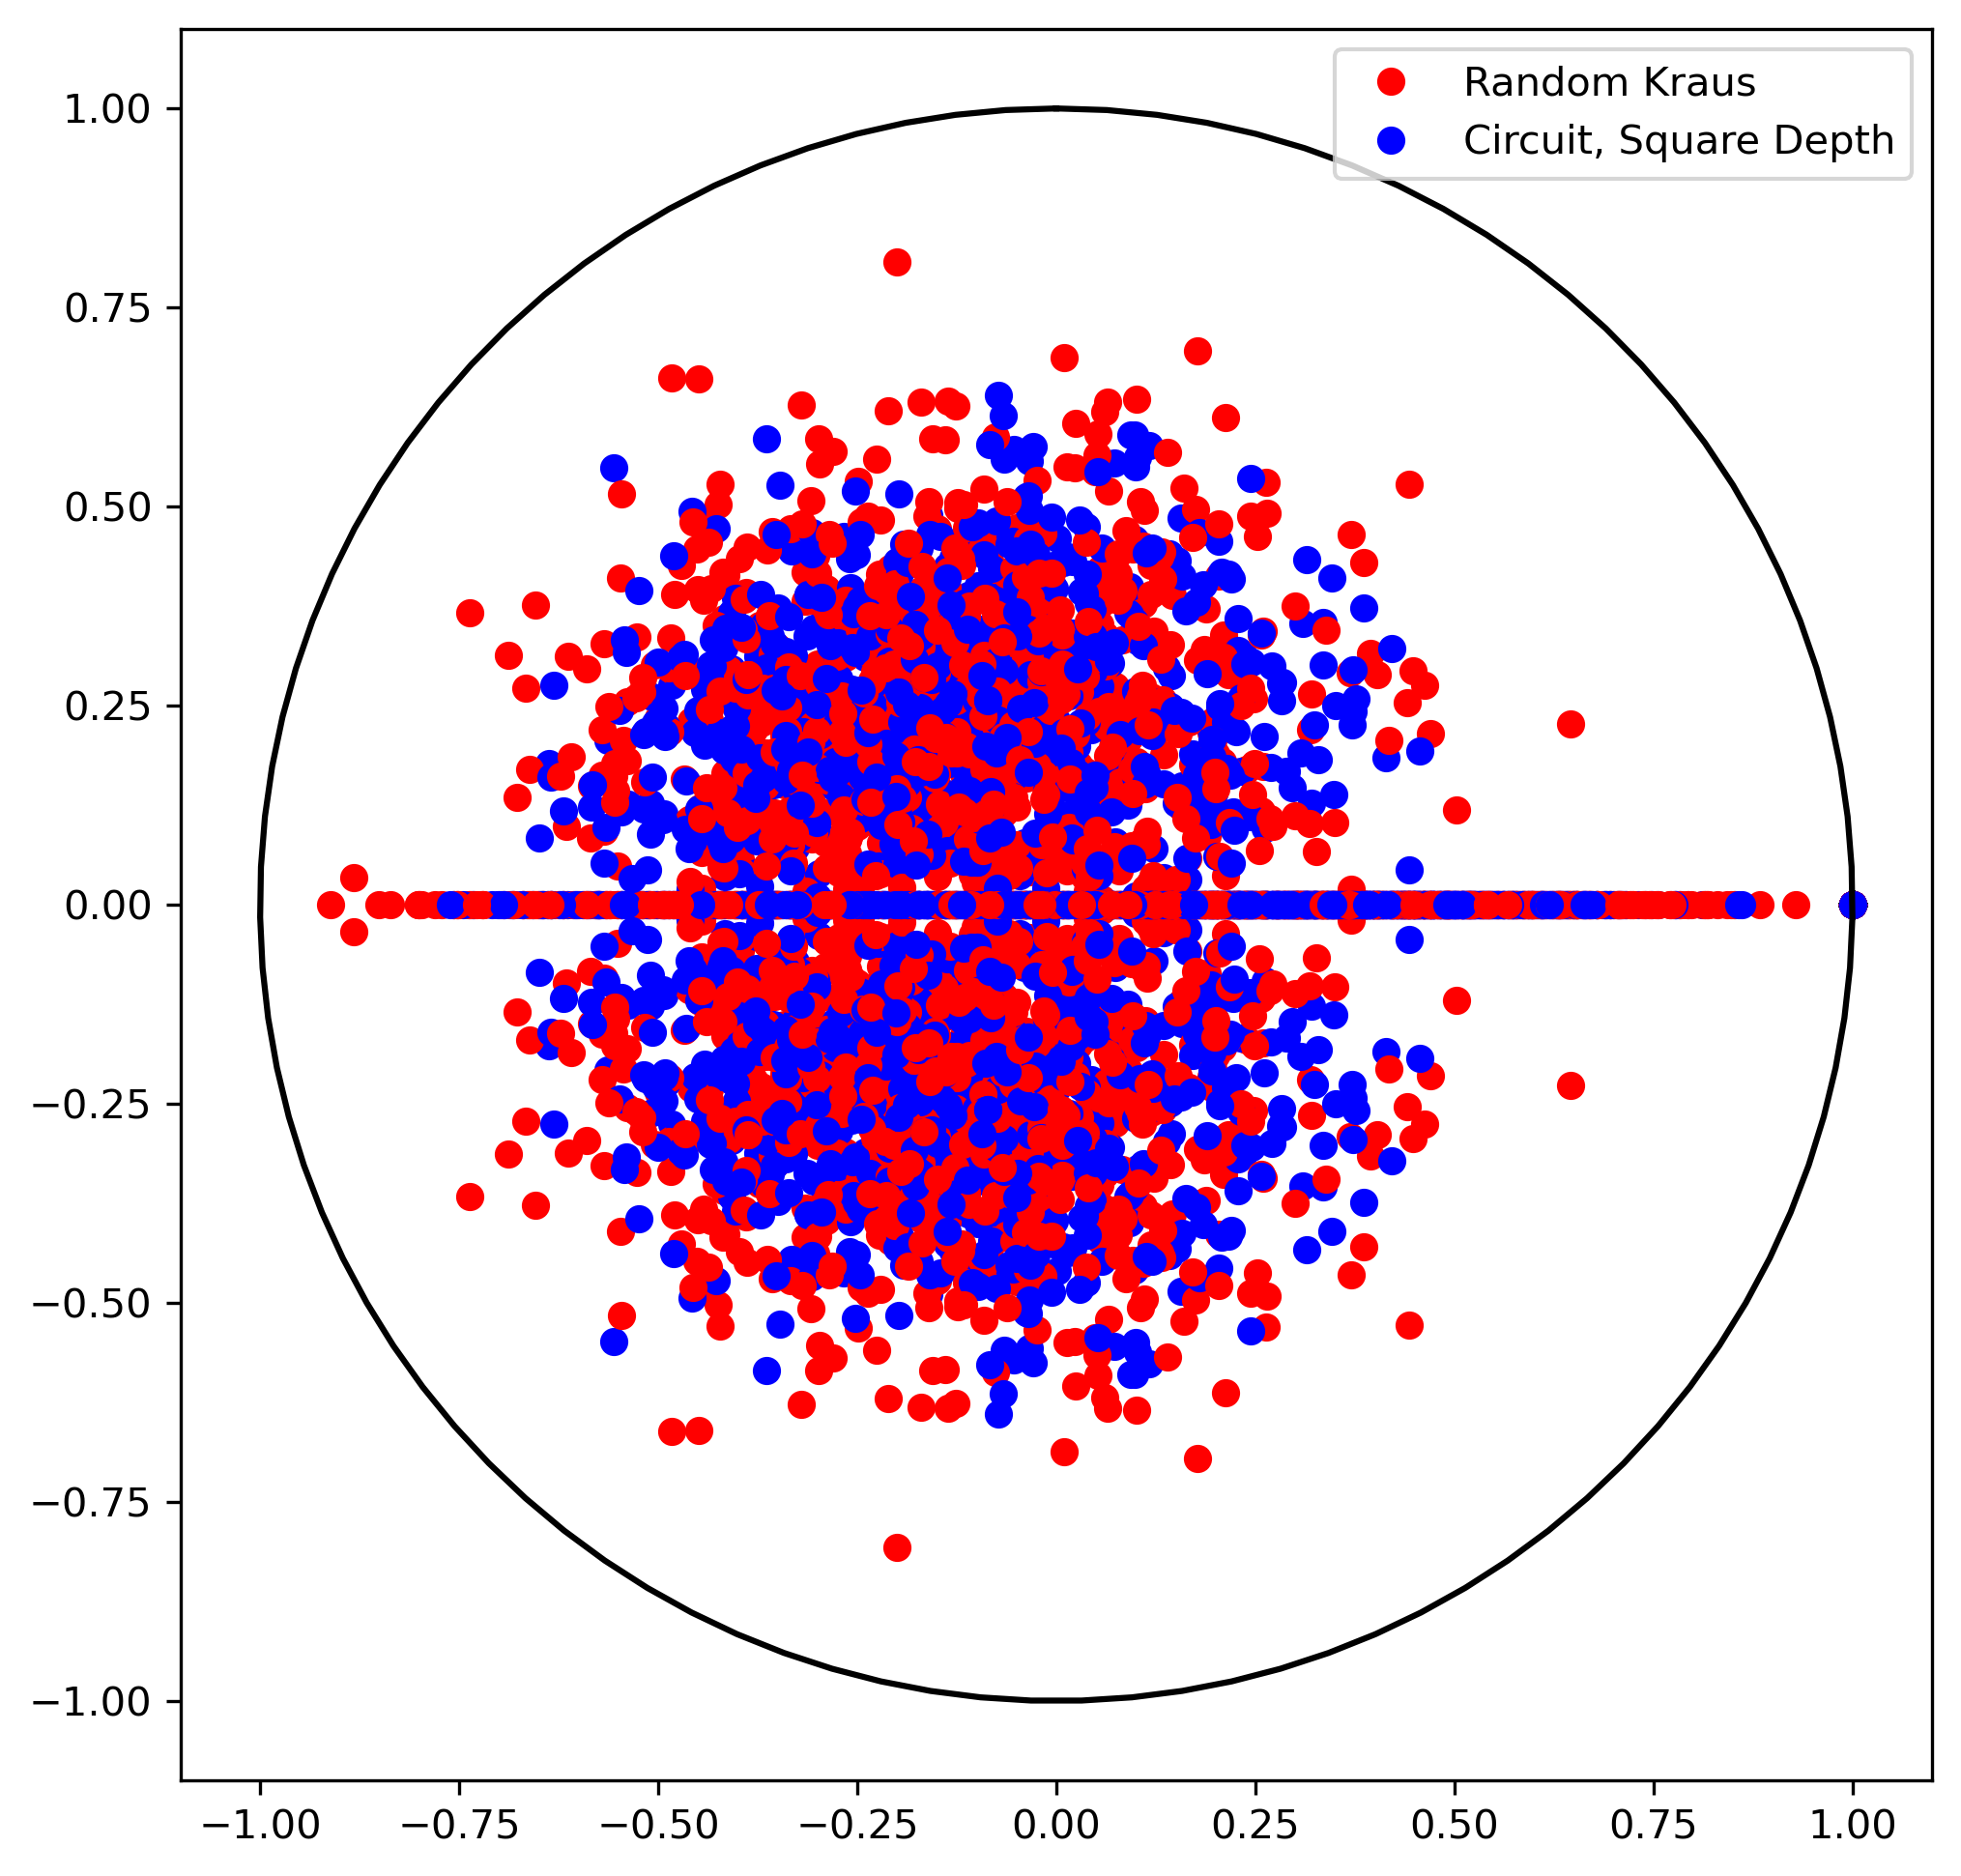

In [13]:
n = 1
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(1000)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff**2)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)
    
    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")
    

plt.legend(["Random Kraus", "Circuit, Square Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/oneQubit_squareDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

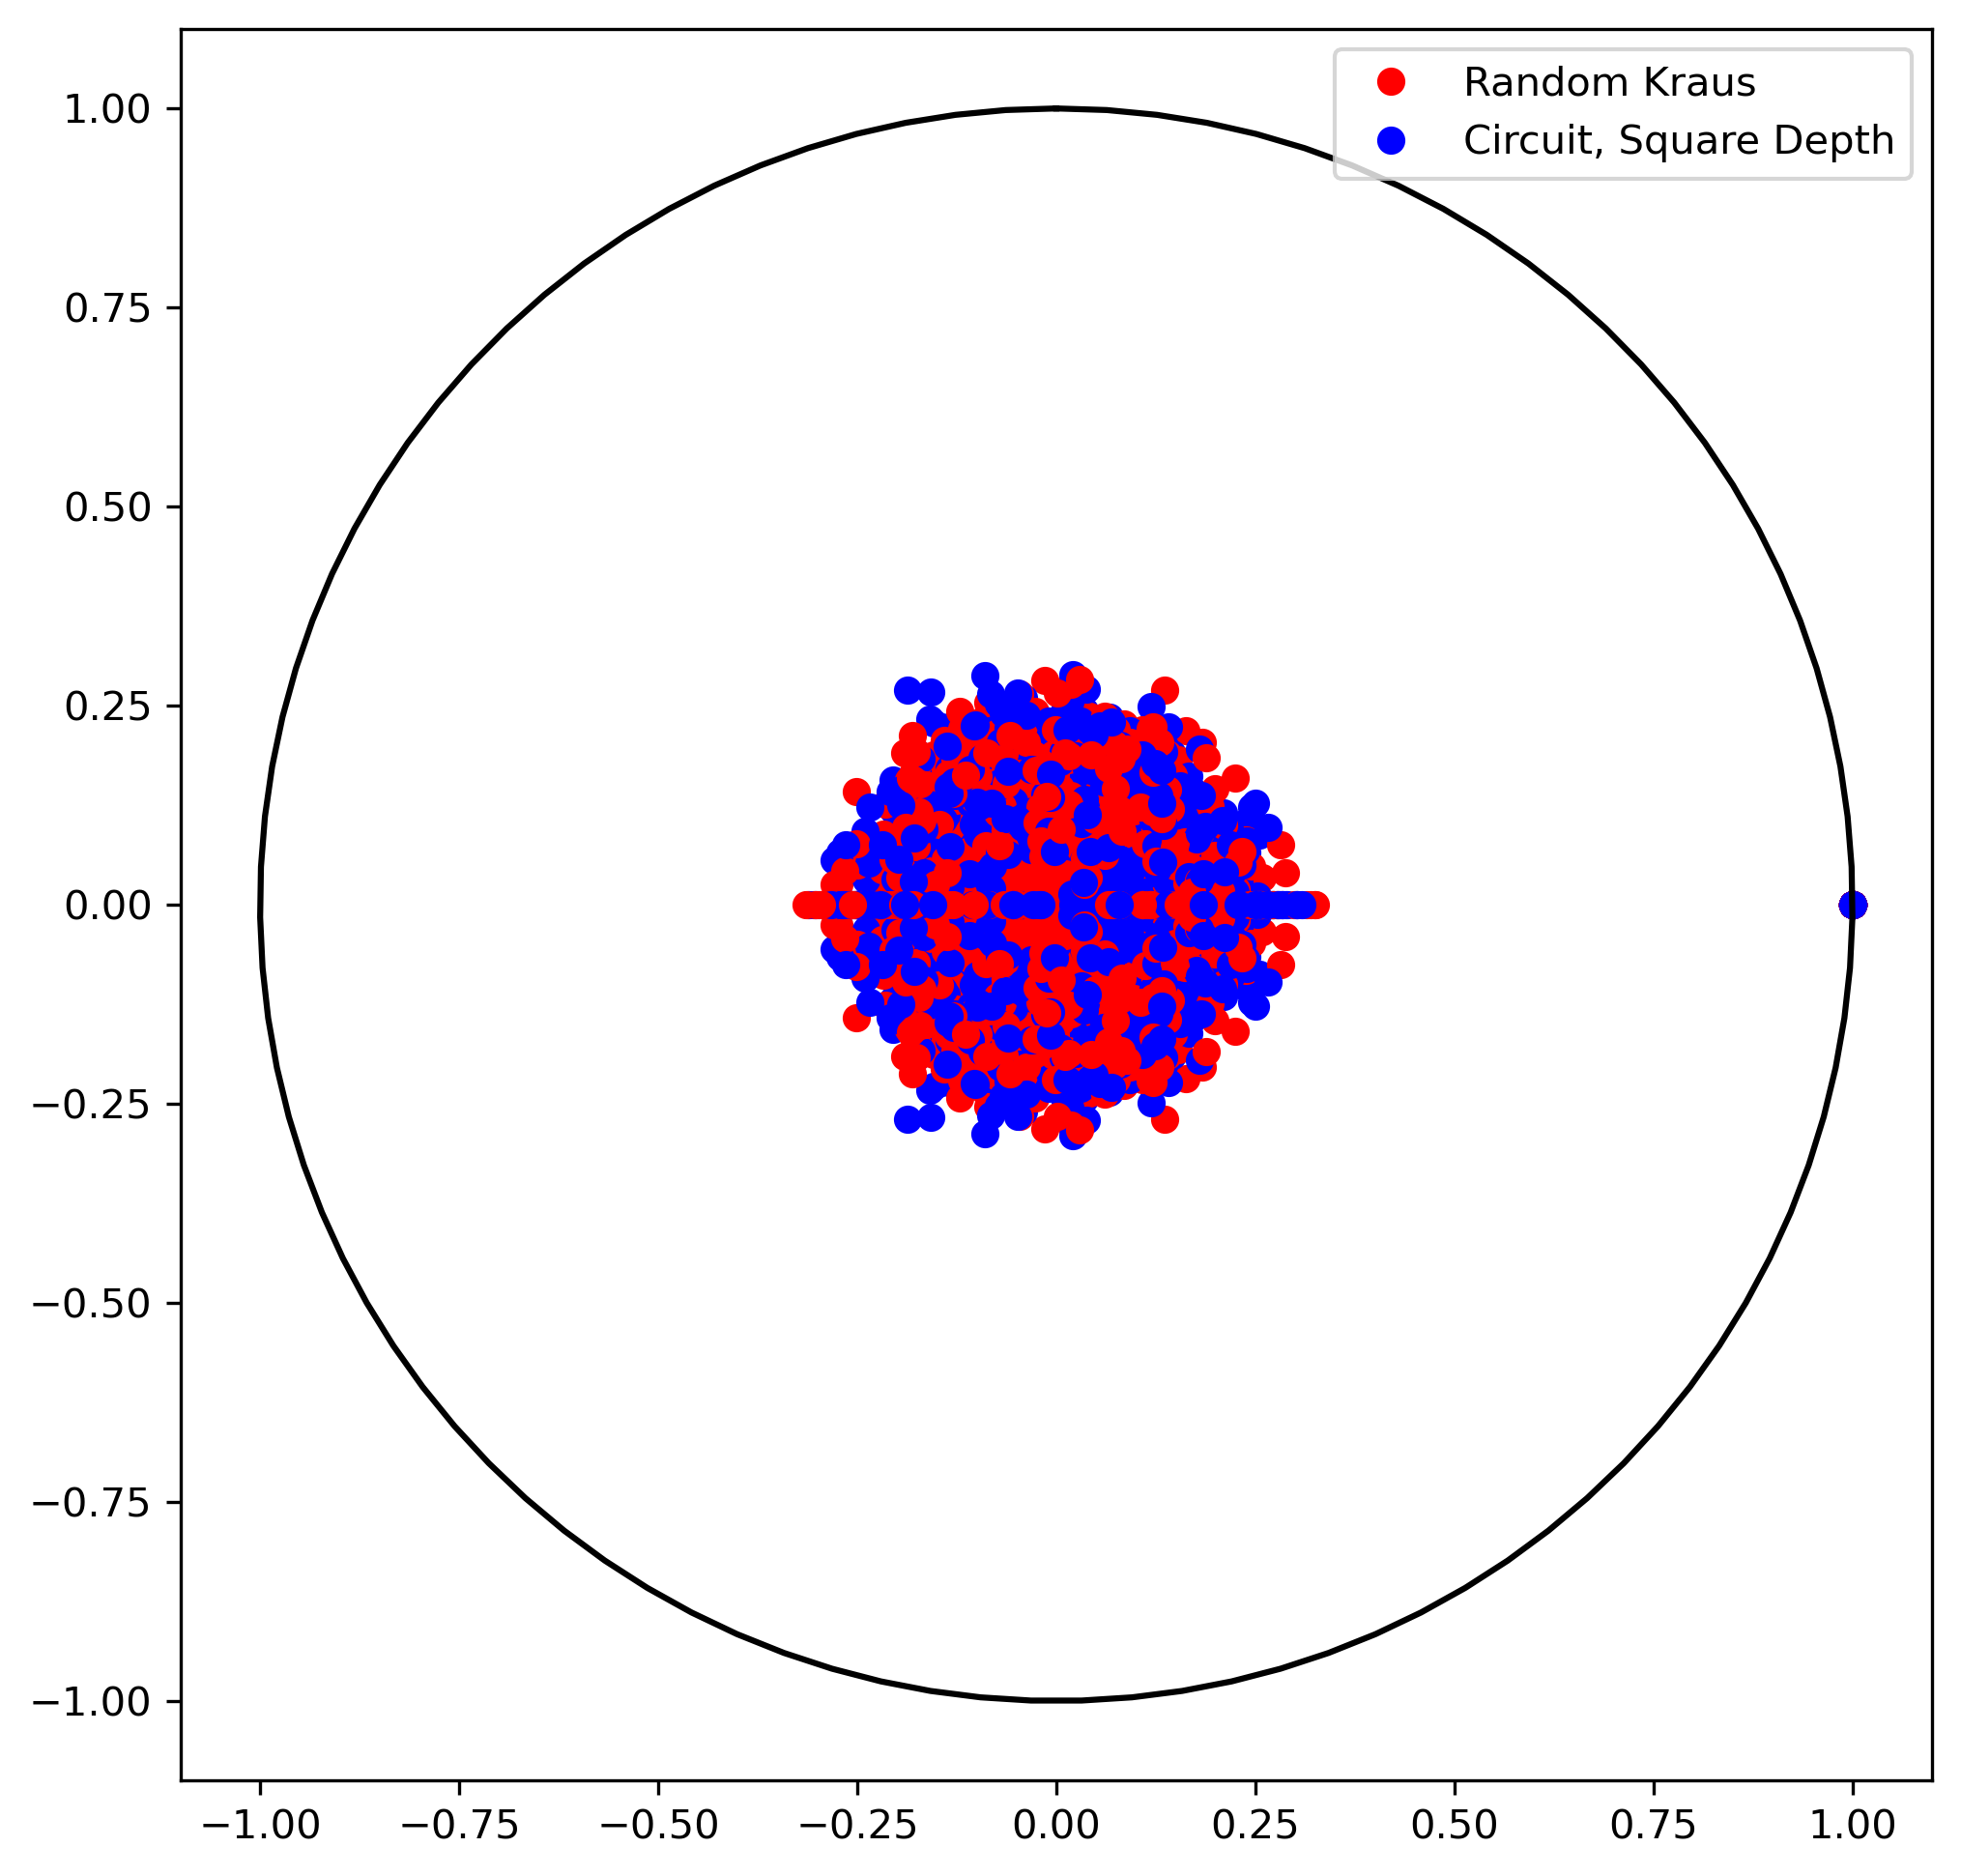

In [14]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff**2)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)
    
    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/twoQubit_squareDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

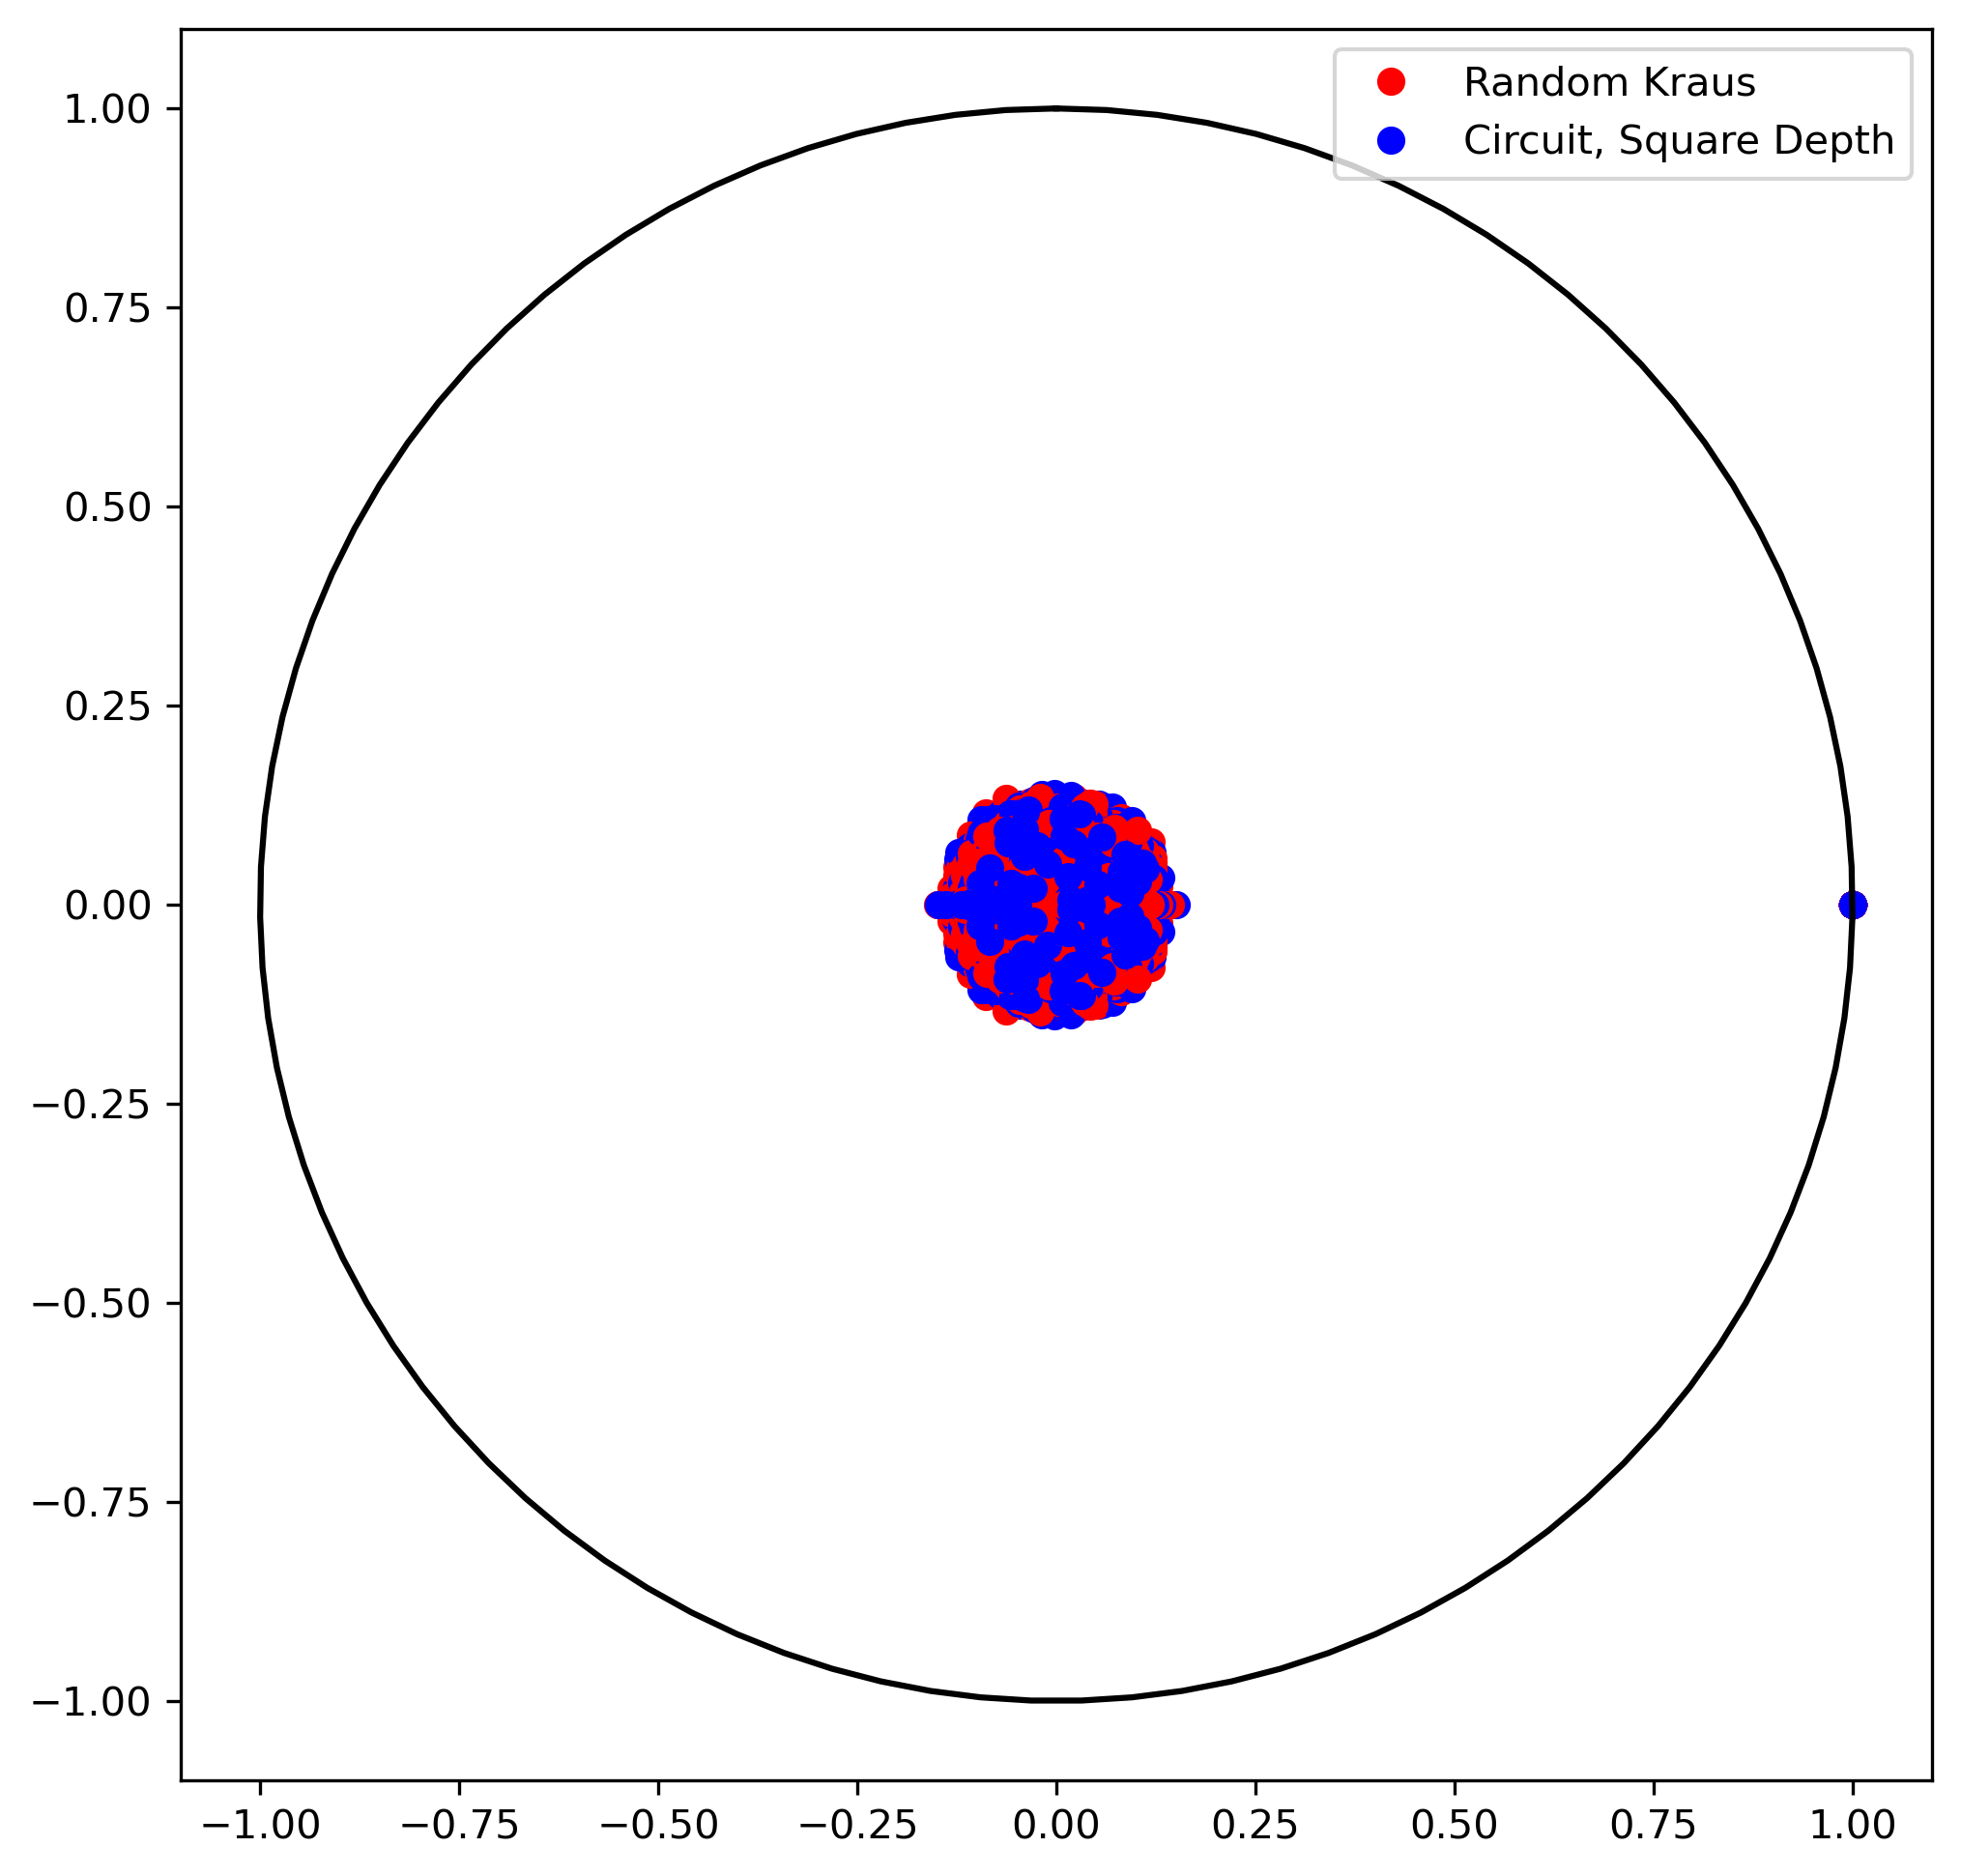

In [15]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff**2)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)
    
    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/threeQubit_squareDepth.pdf")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

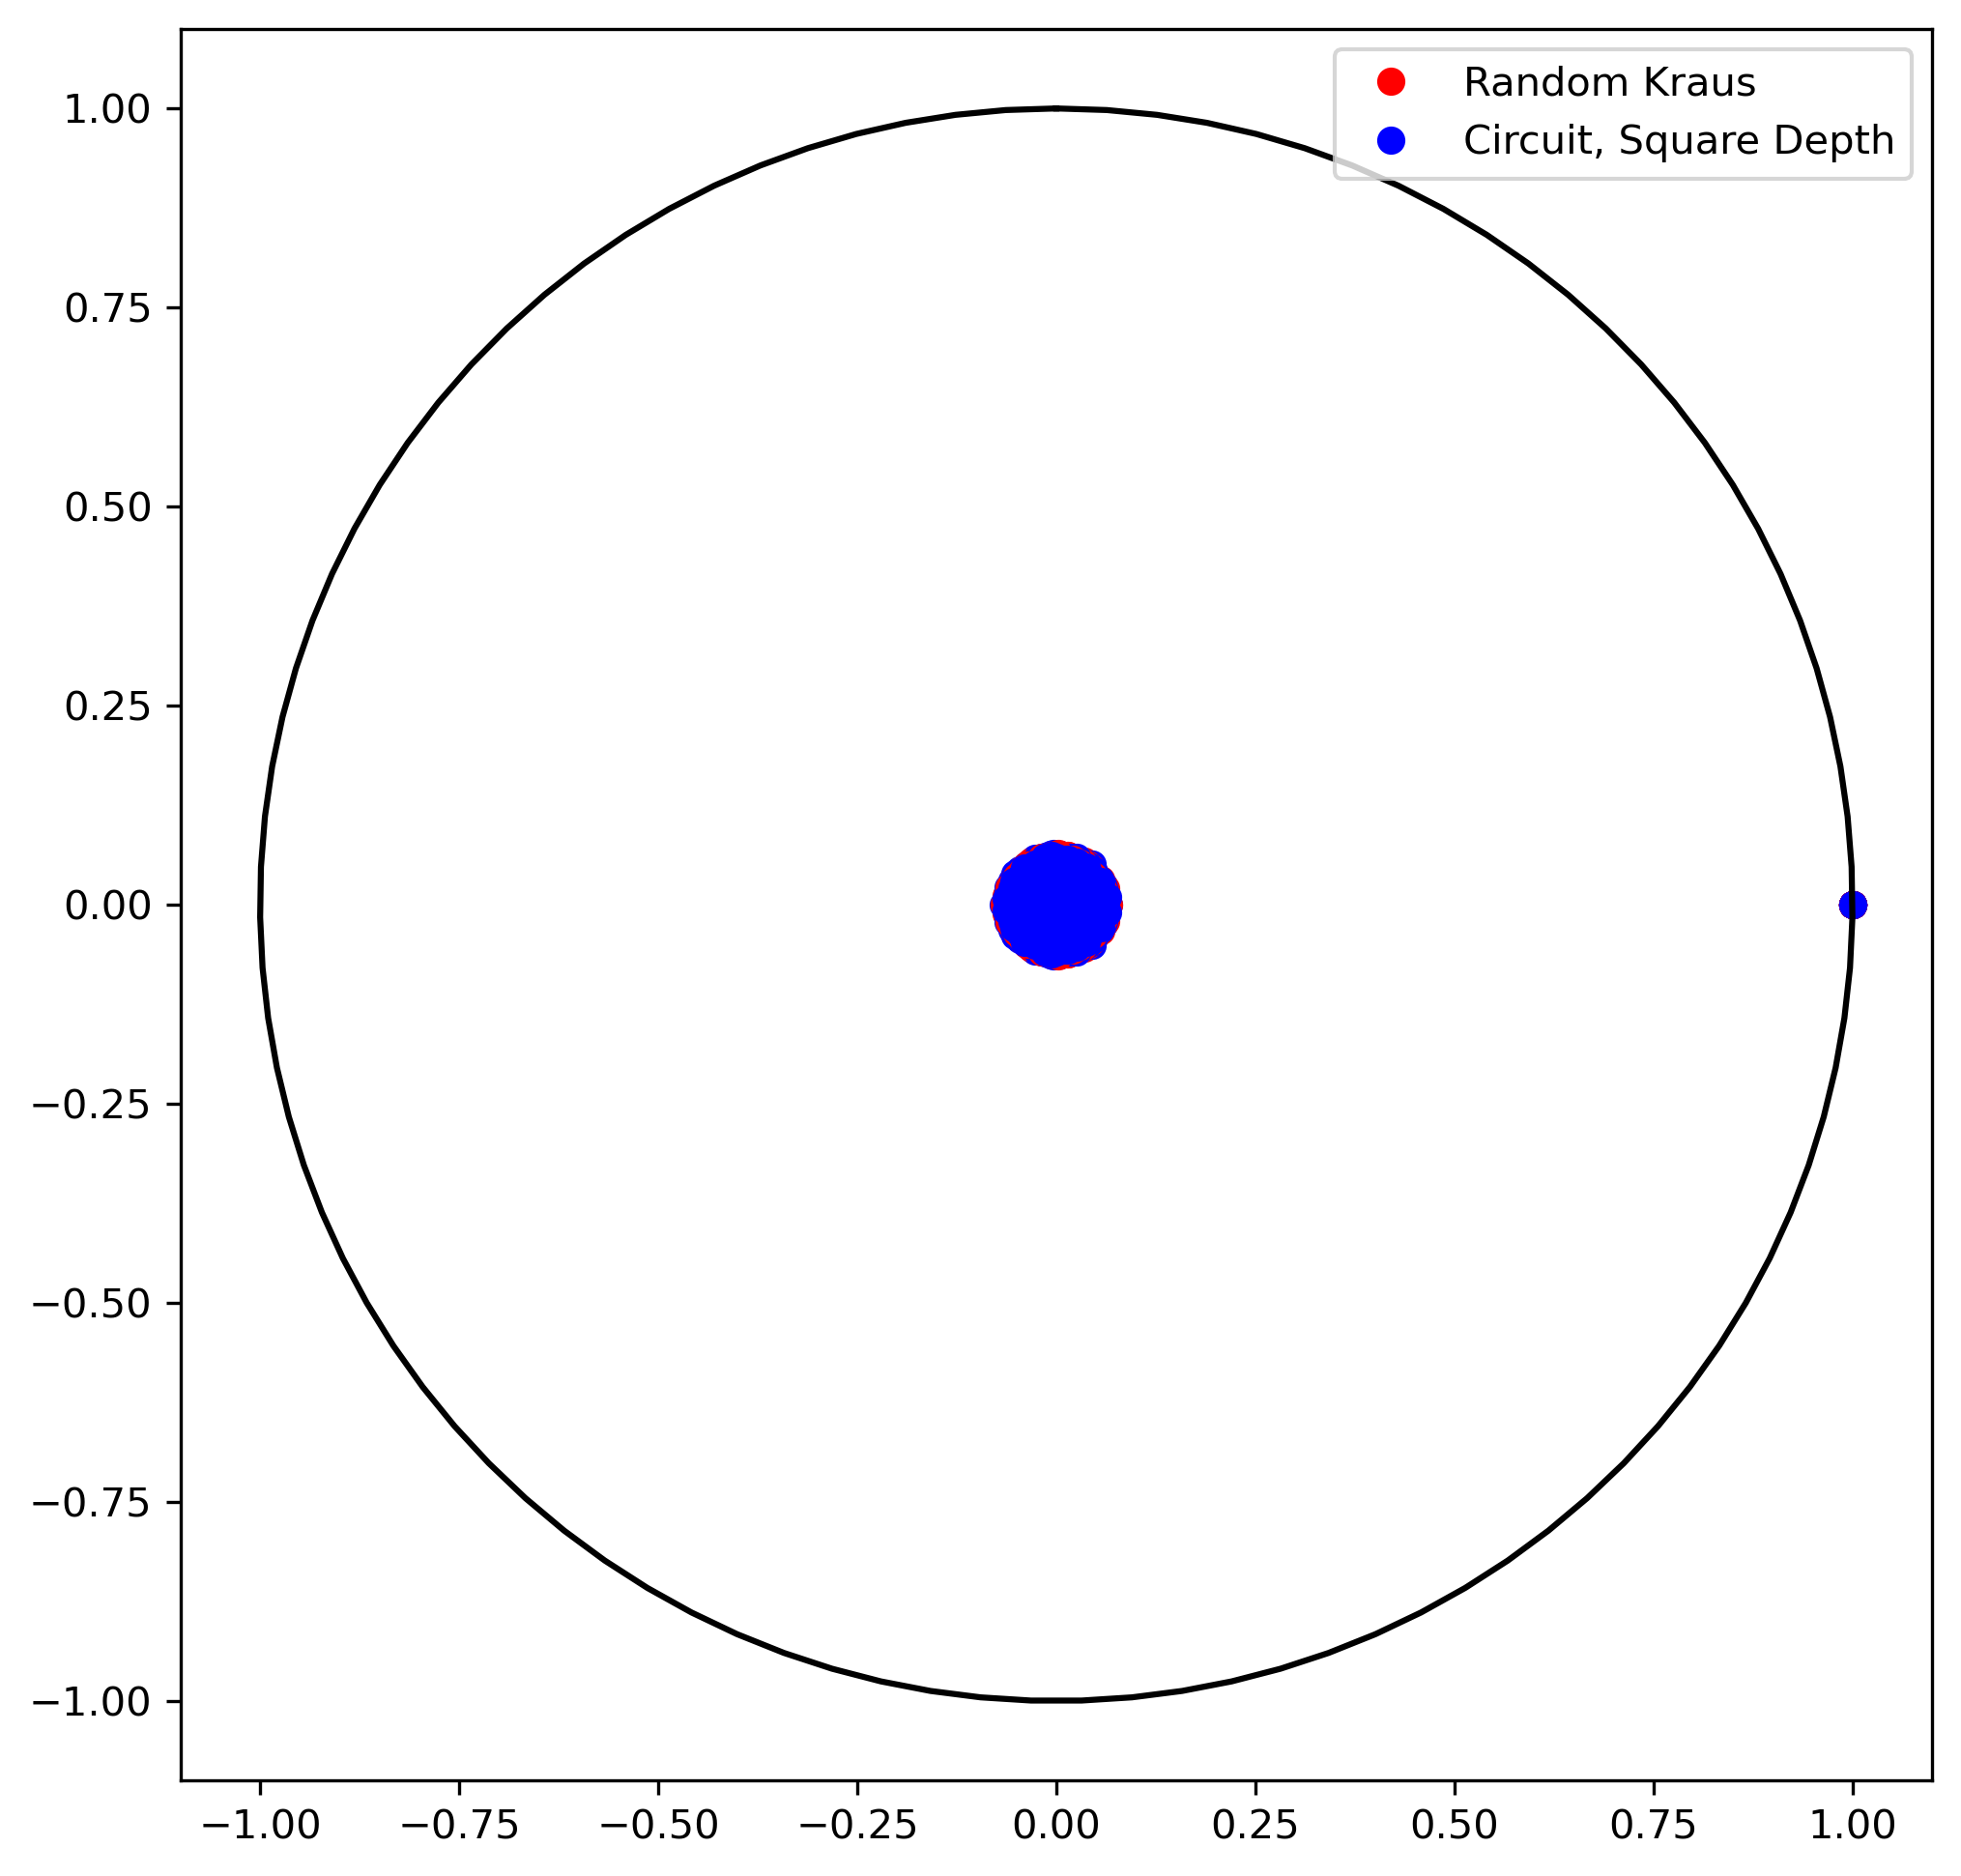

In [17]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(10)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff**2)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fourQubit_squareDepth.pdf")
plt.show()

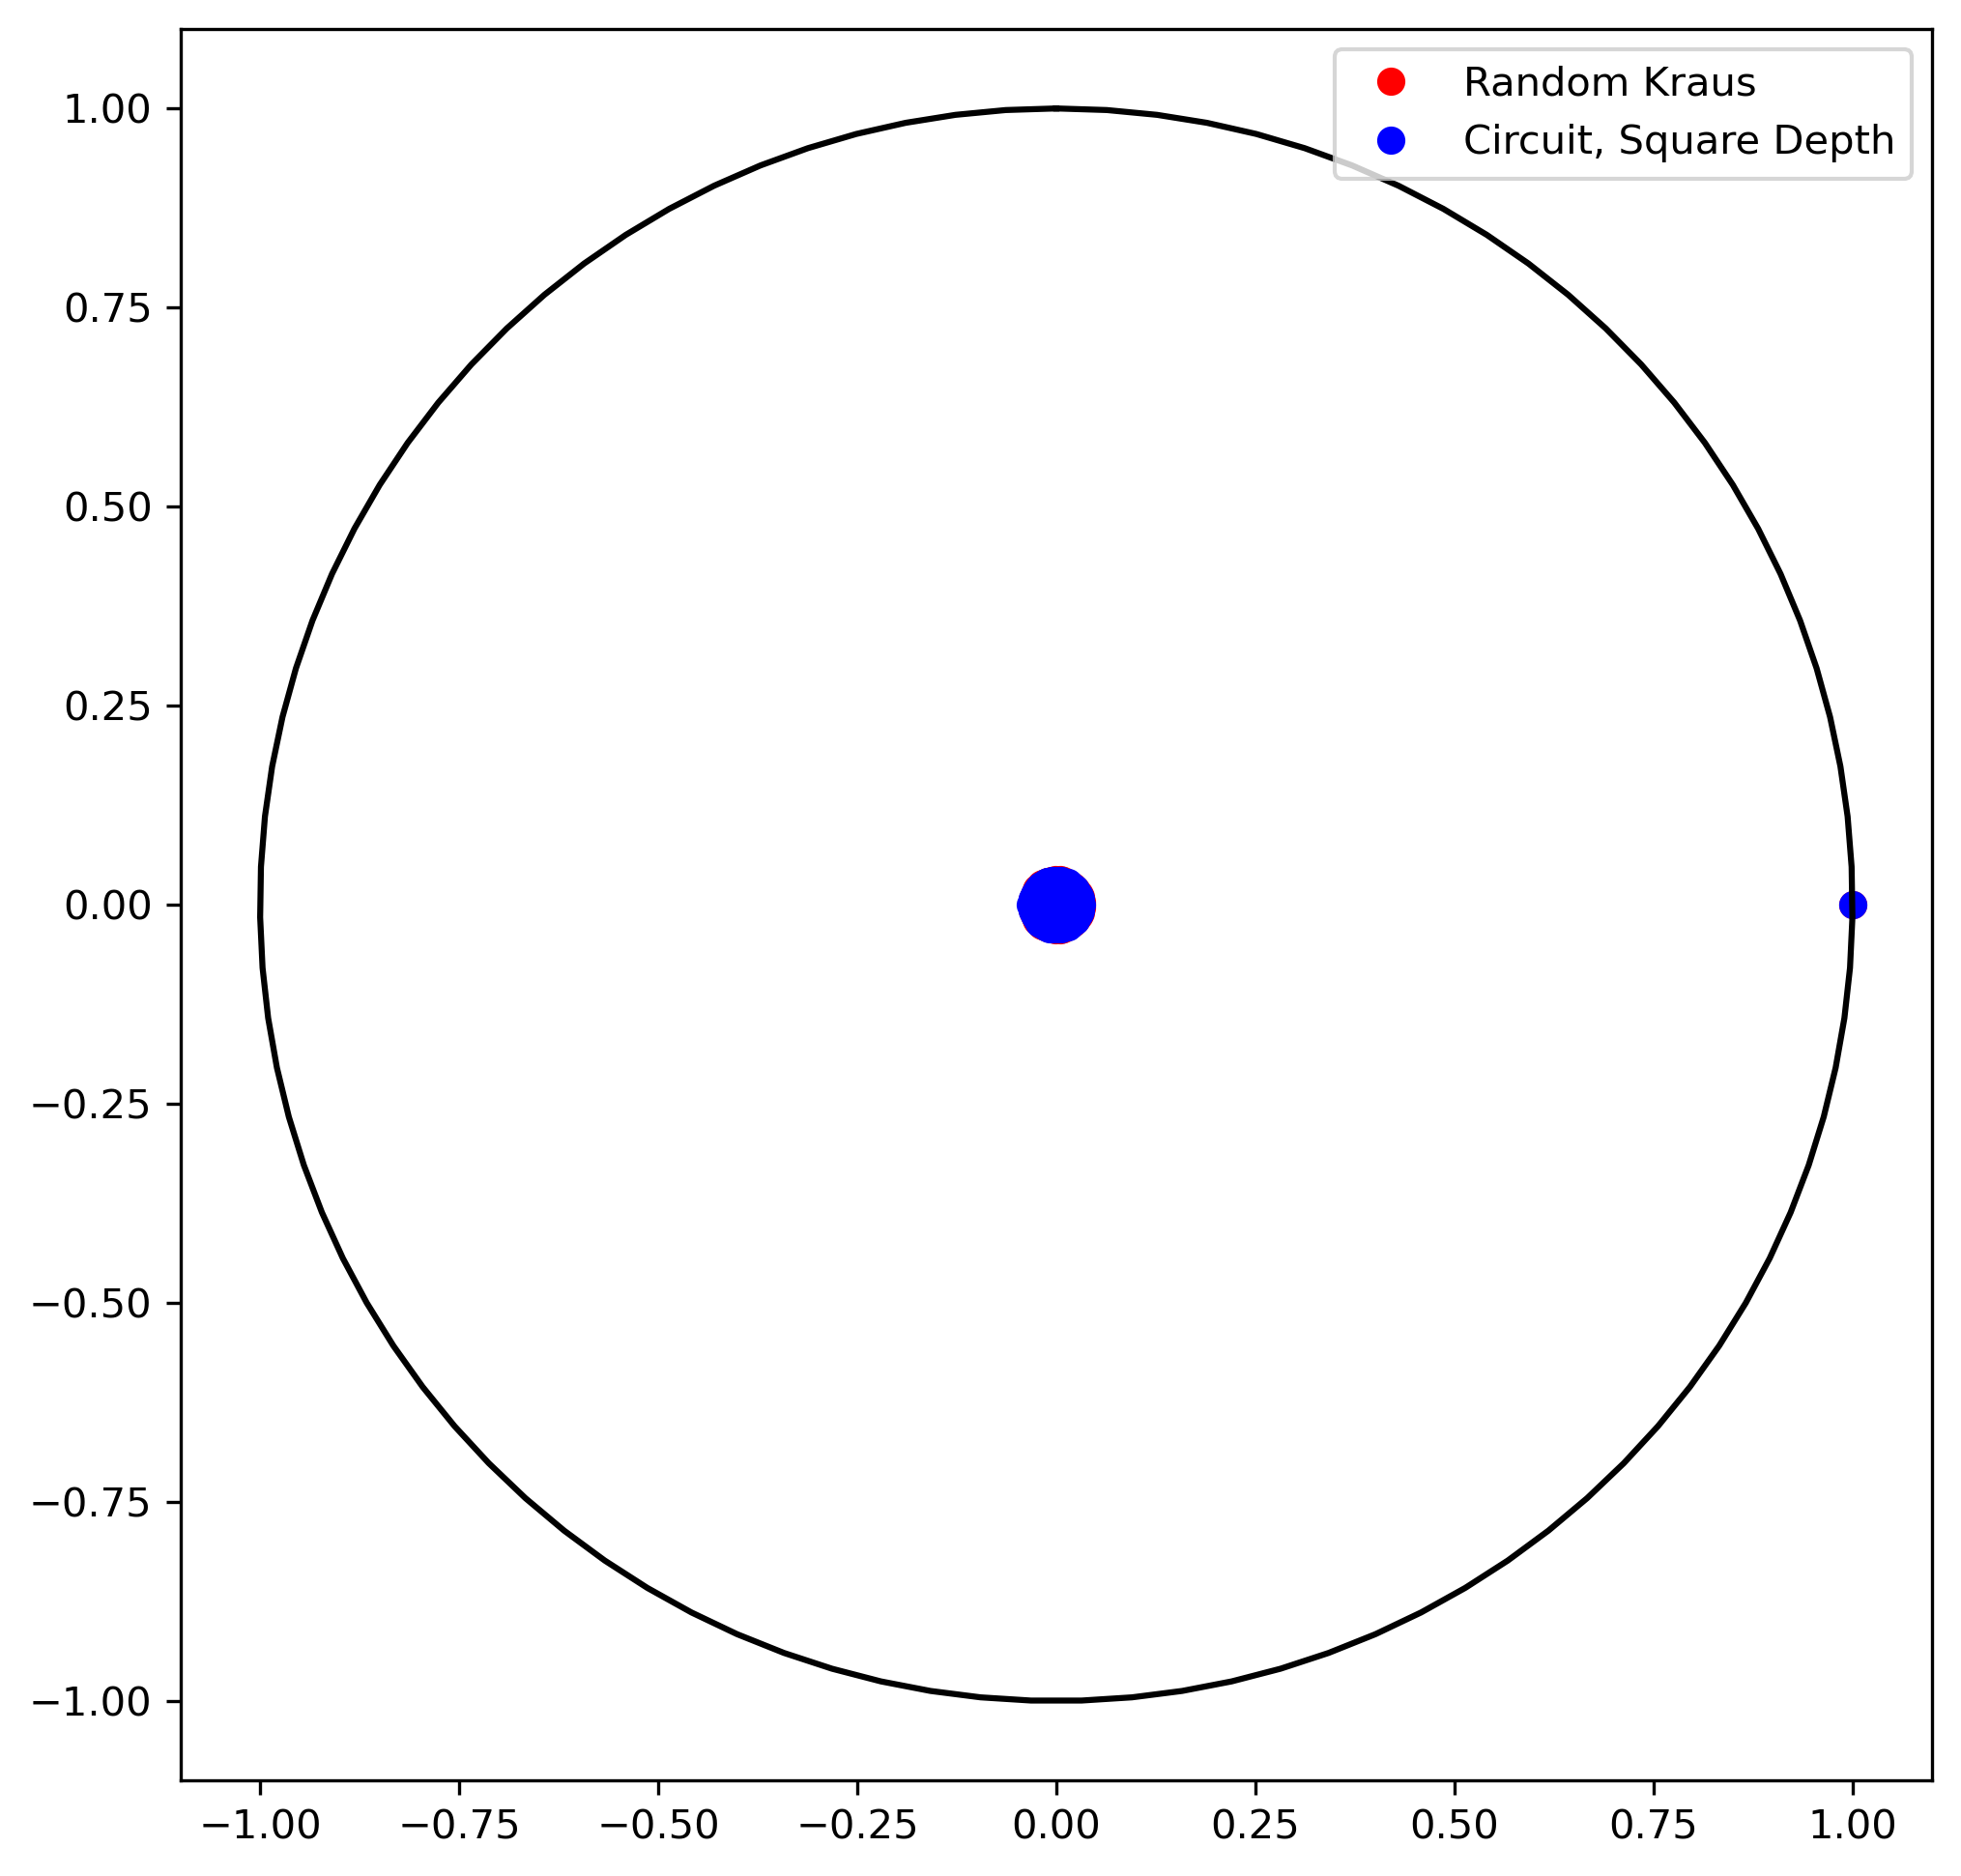

In [18]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in range(1):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=n_eff**2)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fiveQubit_squareDepth.pdf")
plt.show()

### Square Root Depth

  0%|          | 0/1000 [00:00<?, ?it/s]

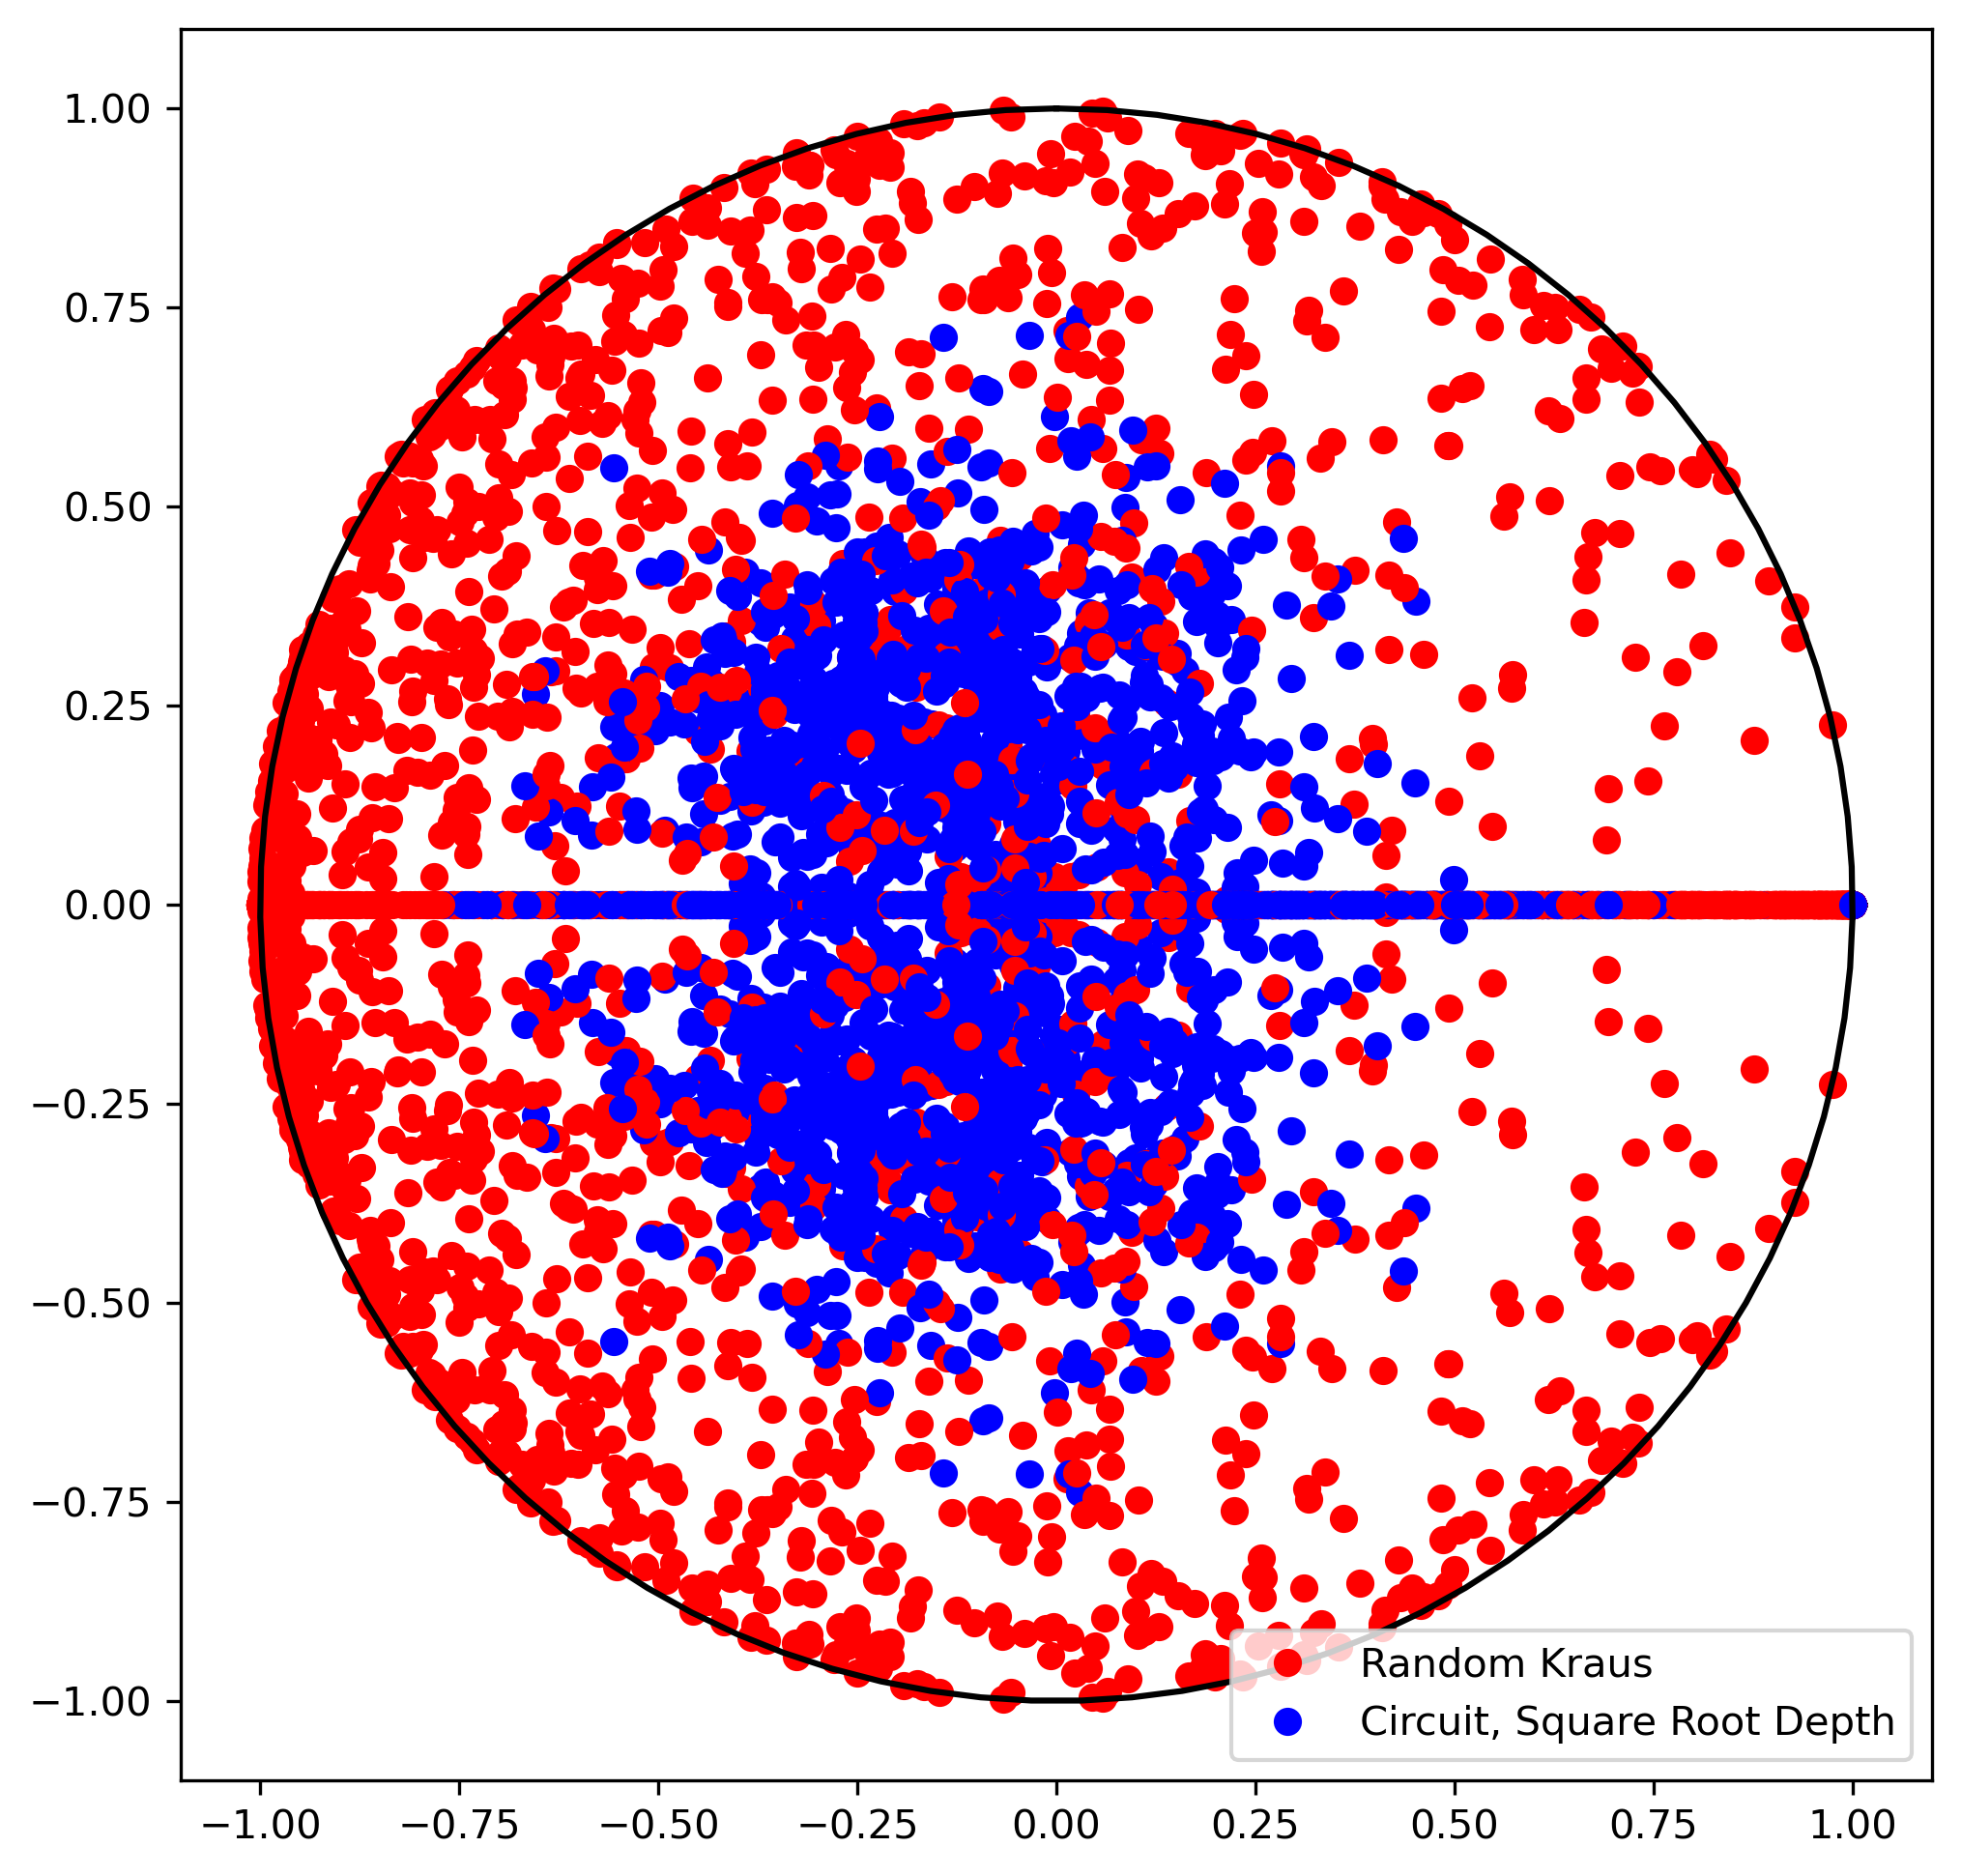

In [19]:
n = 1
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(1000)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=round(np.sqrt(n_eff)))
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Root Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/oneQubit_squareRootDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

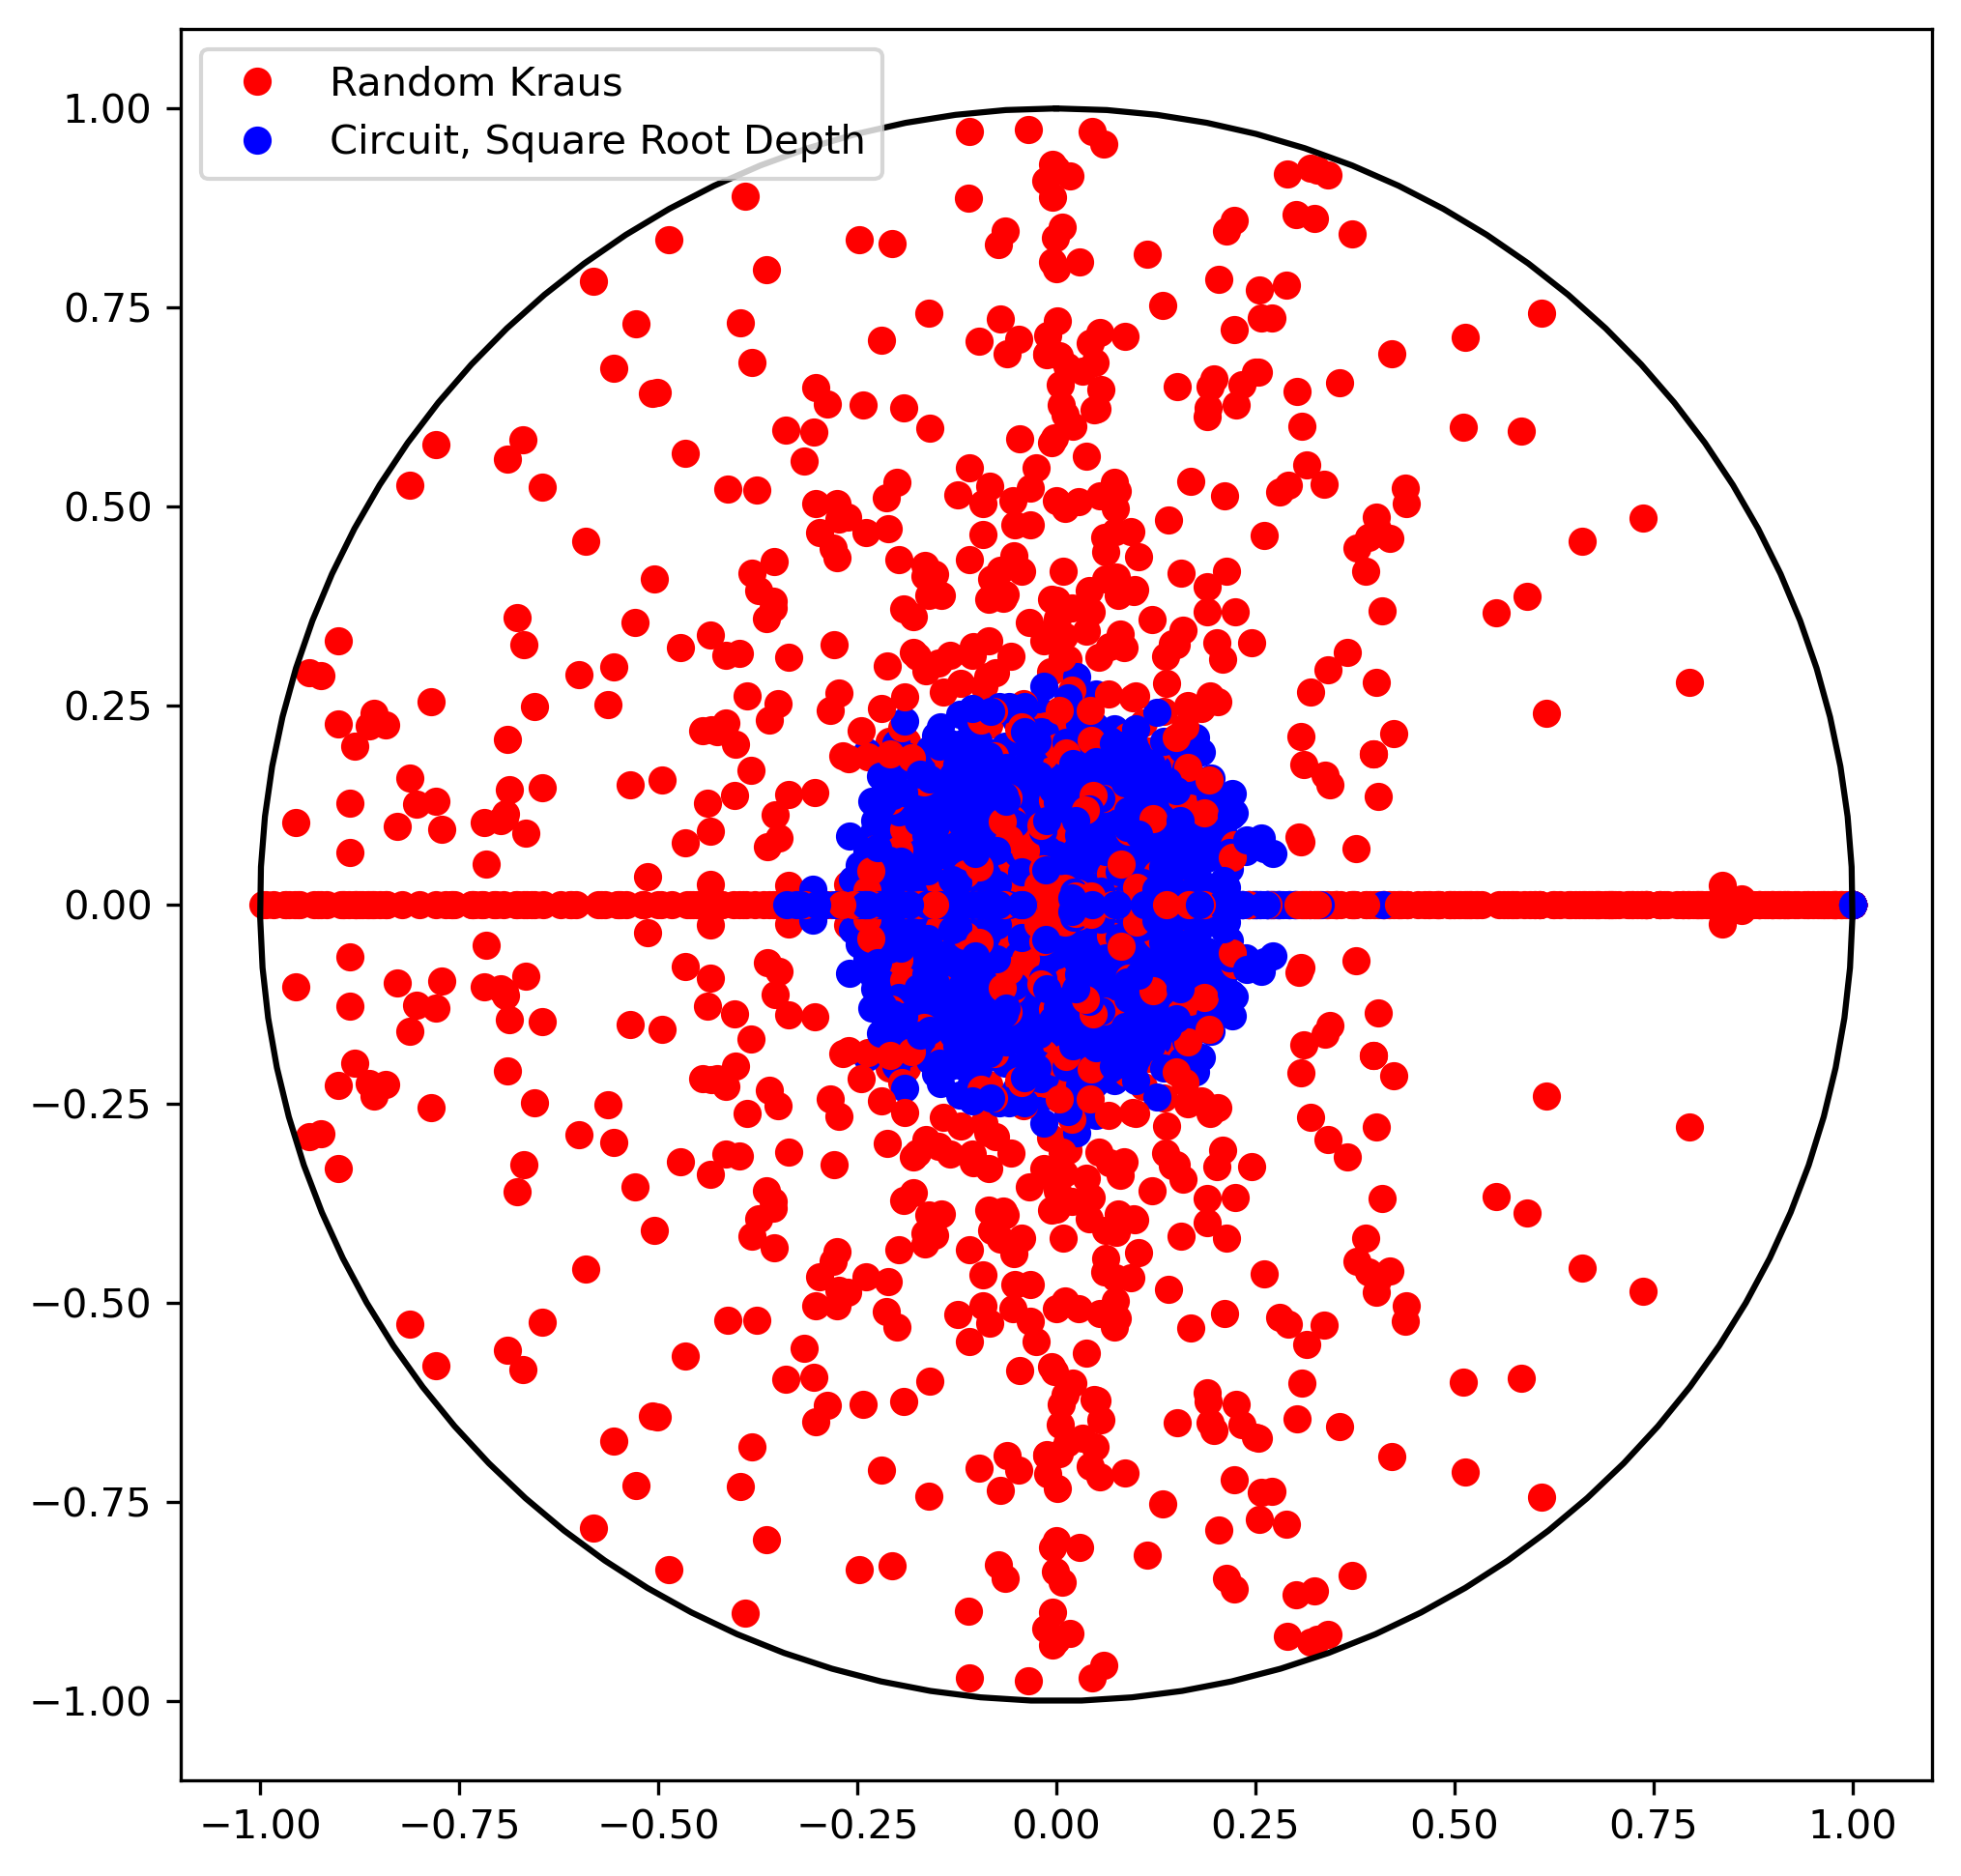

In [20]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=round(np.sqrt(n_eff)))
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Root Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/twoQubit_squareRootDepth.pdf")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

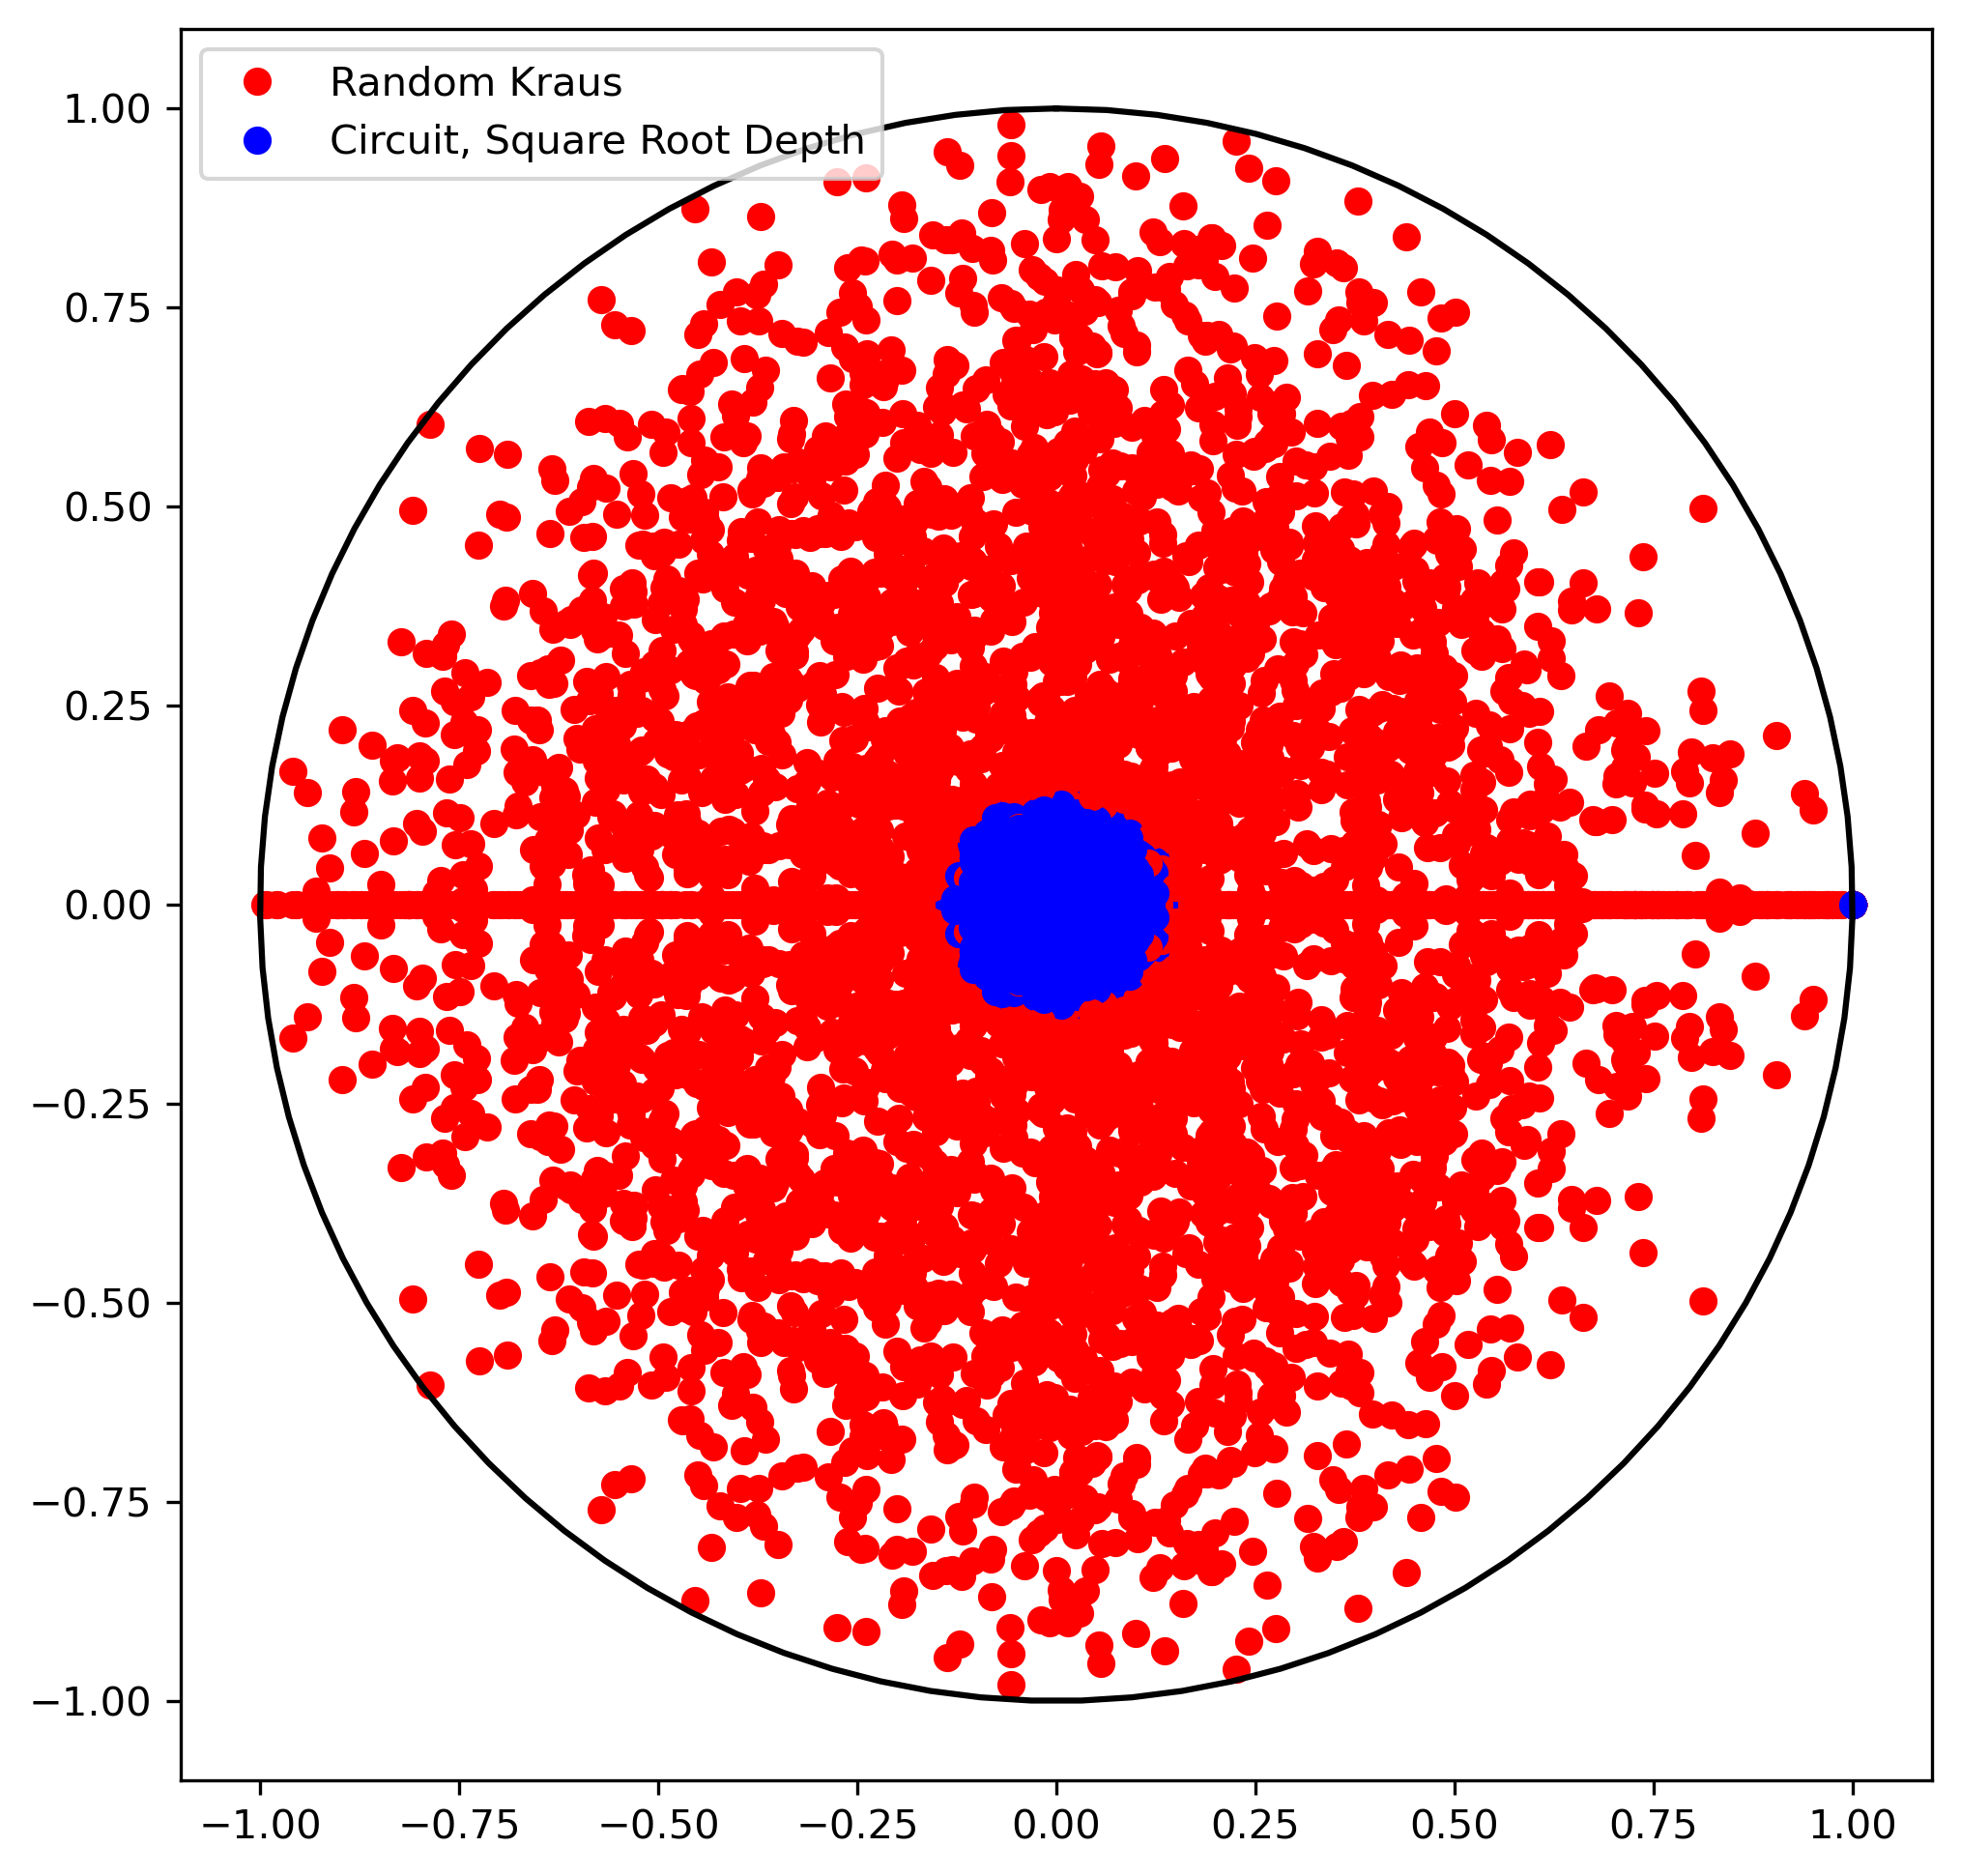

In [21]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(100)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=round(np.sqrt(n_eff)))
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Root Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/threeQubit_squareRootDepth.pdf")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

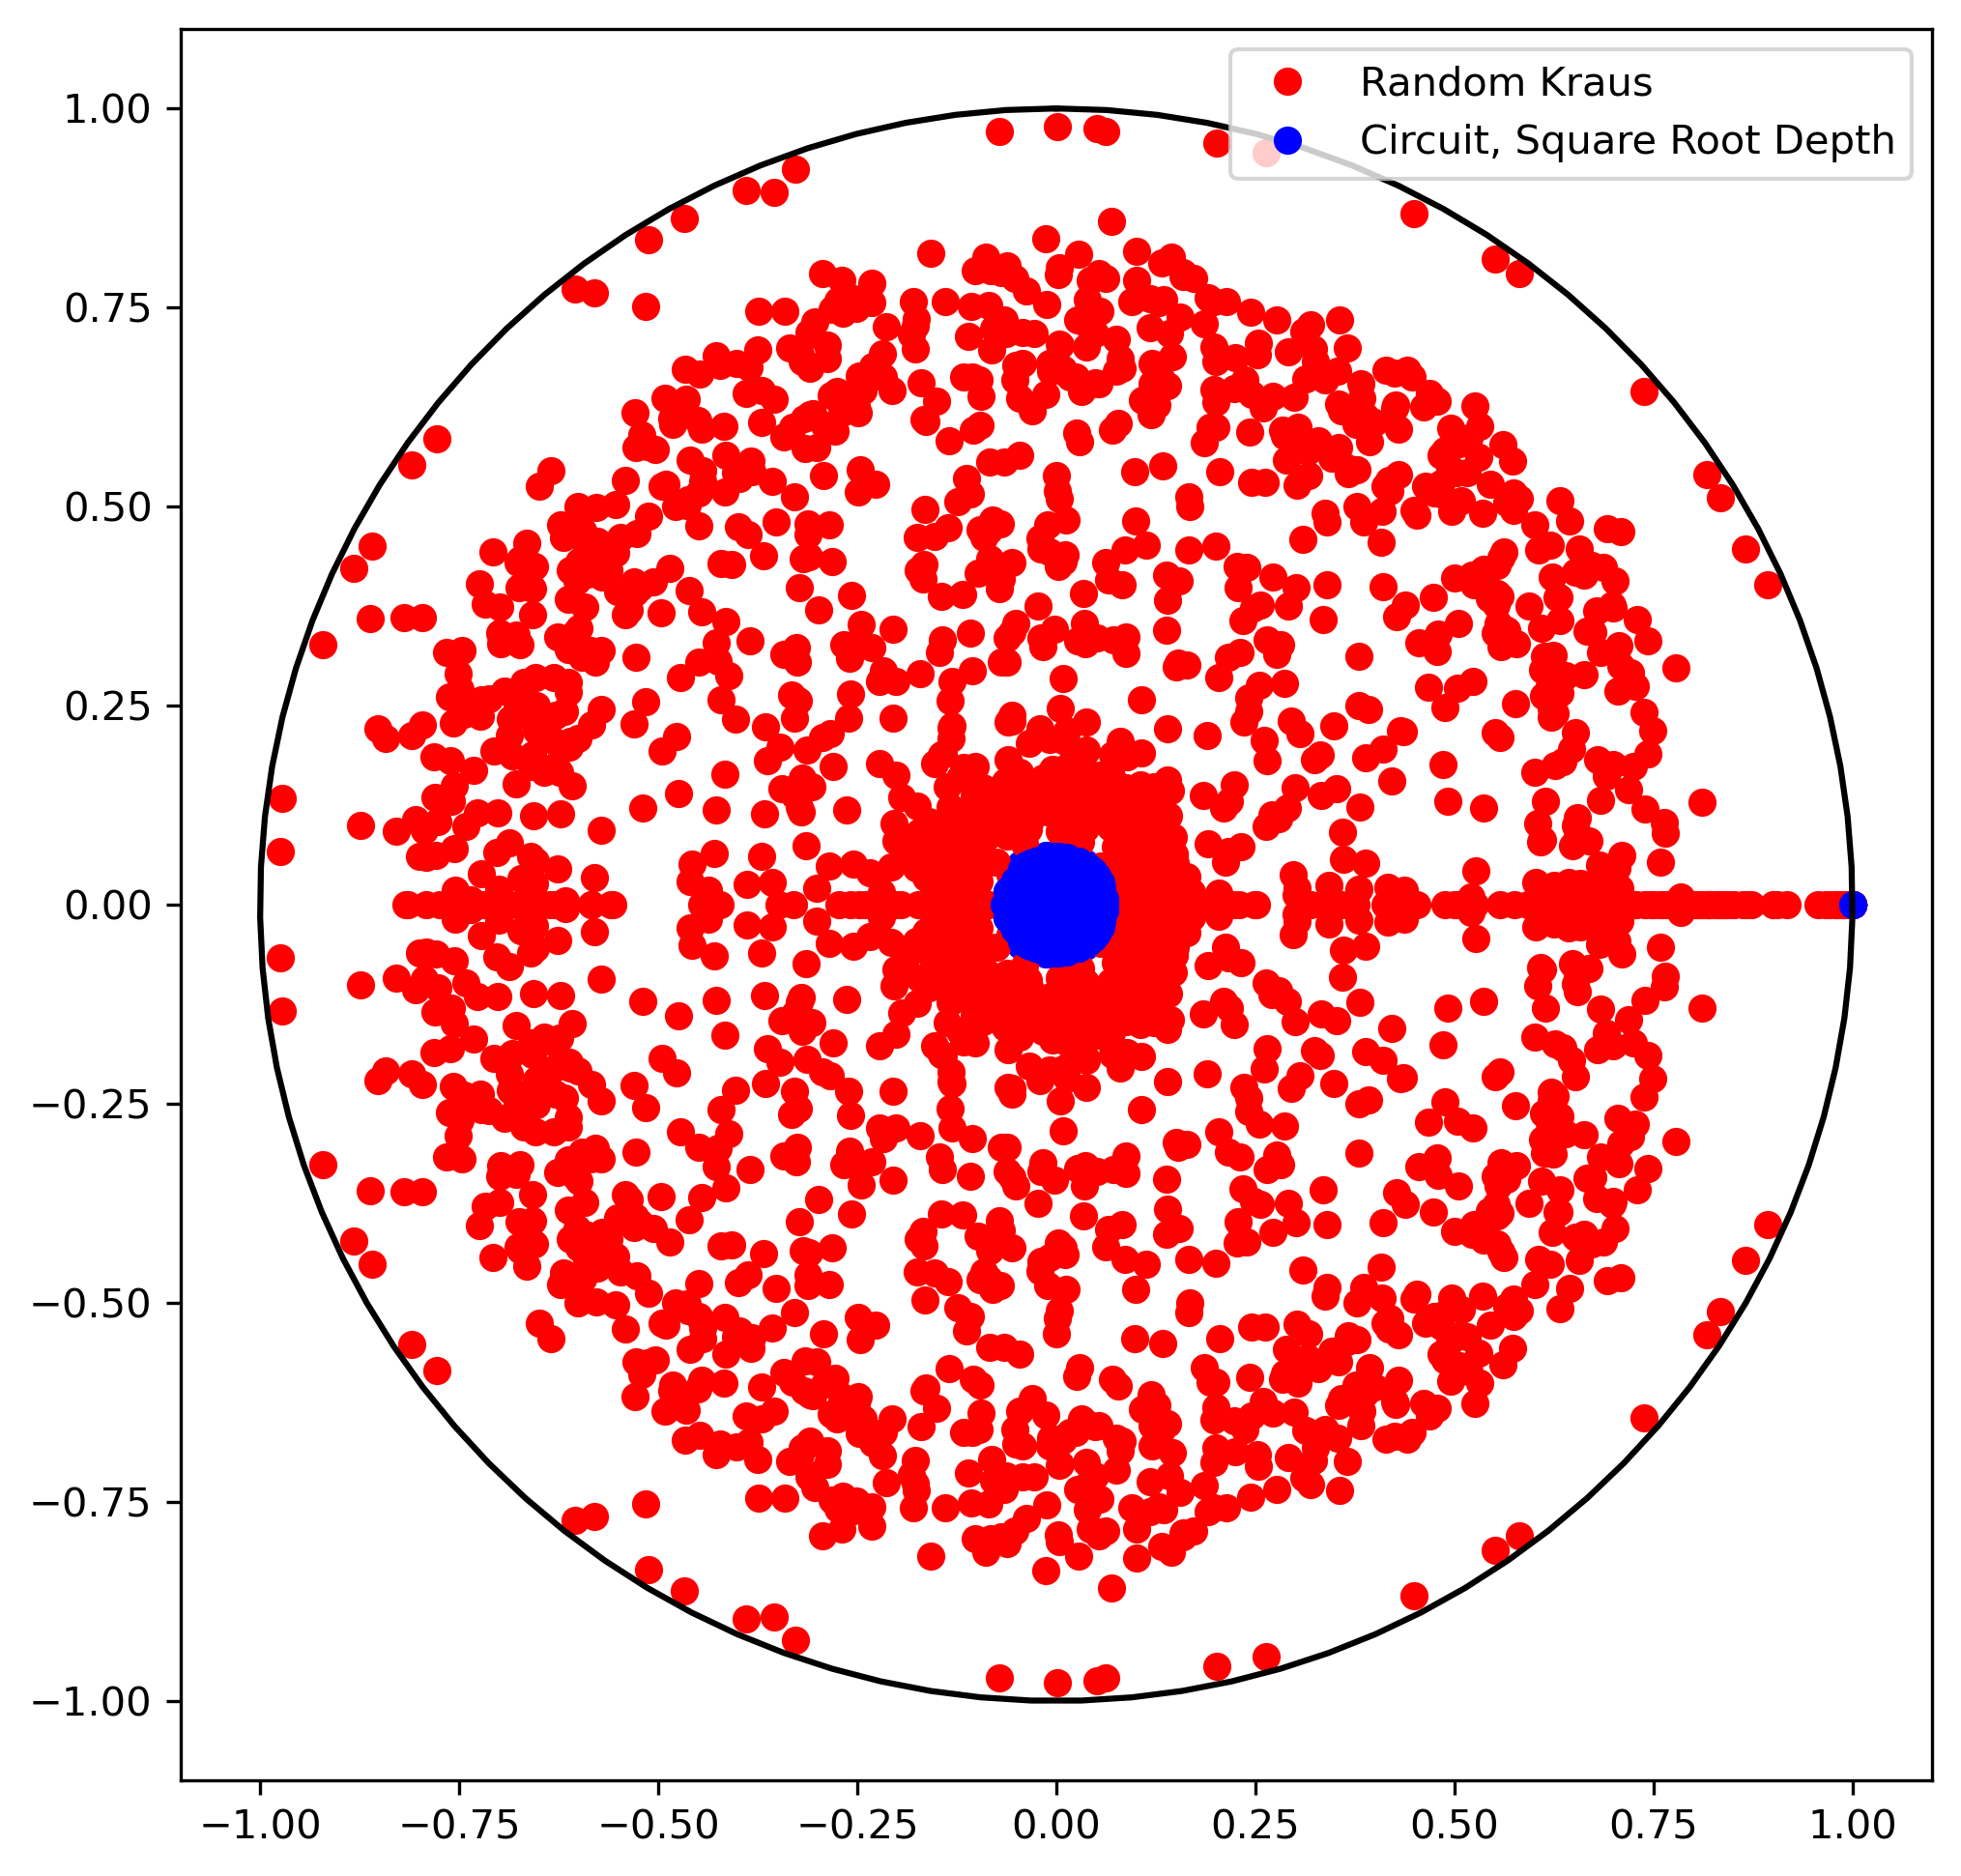

In [22]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(10)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=round(np.sqrt(n_eff)))
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Root Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fourQubit_squareRootDepth.pdf")
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

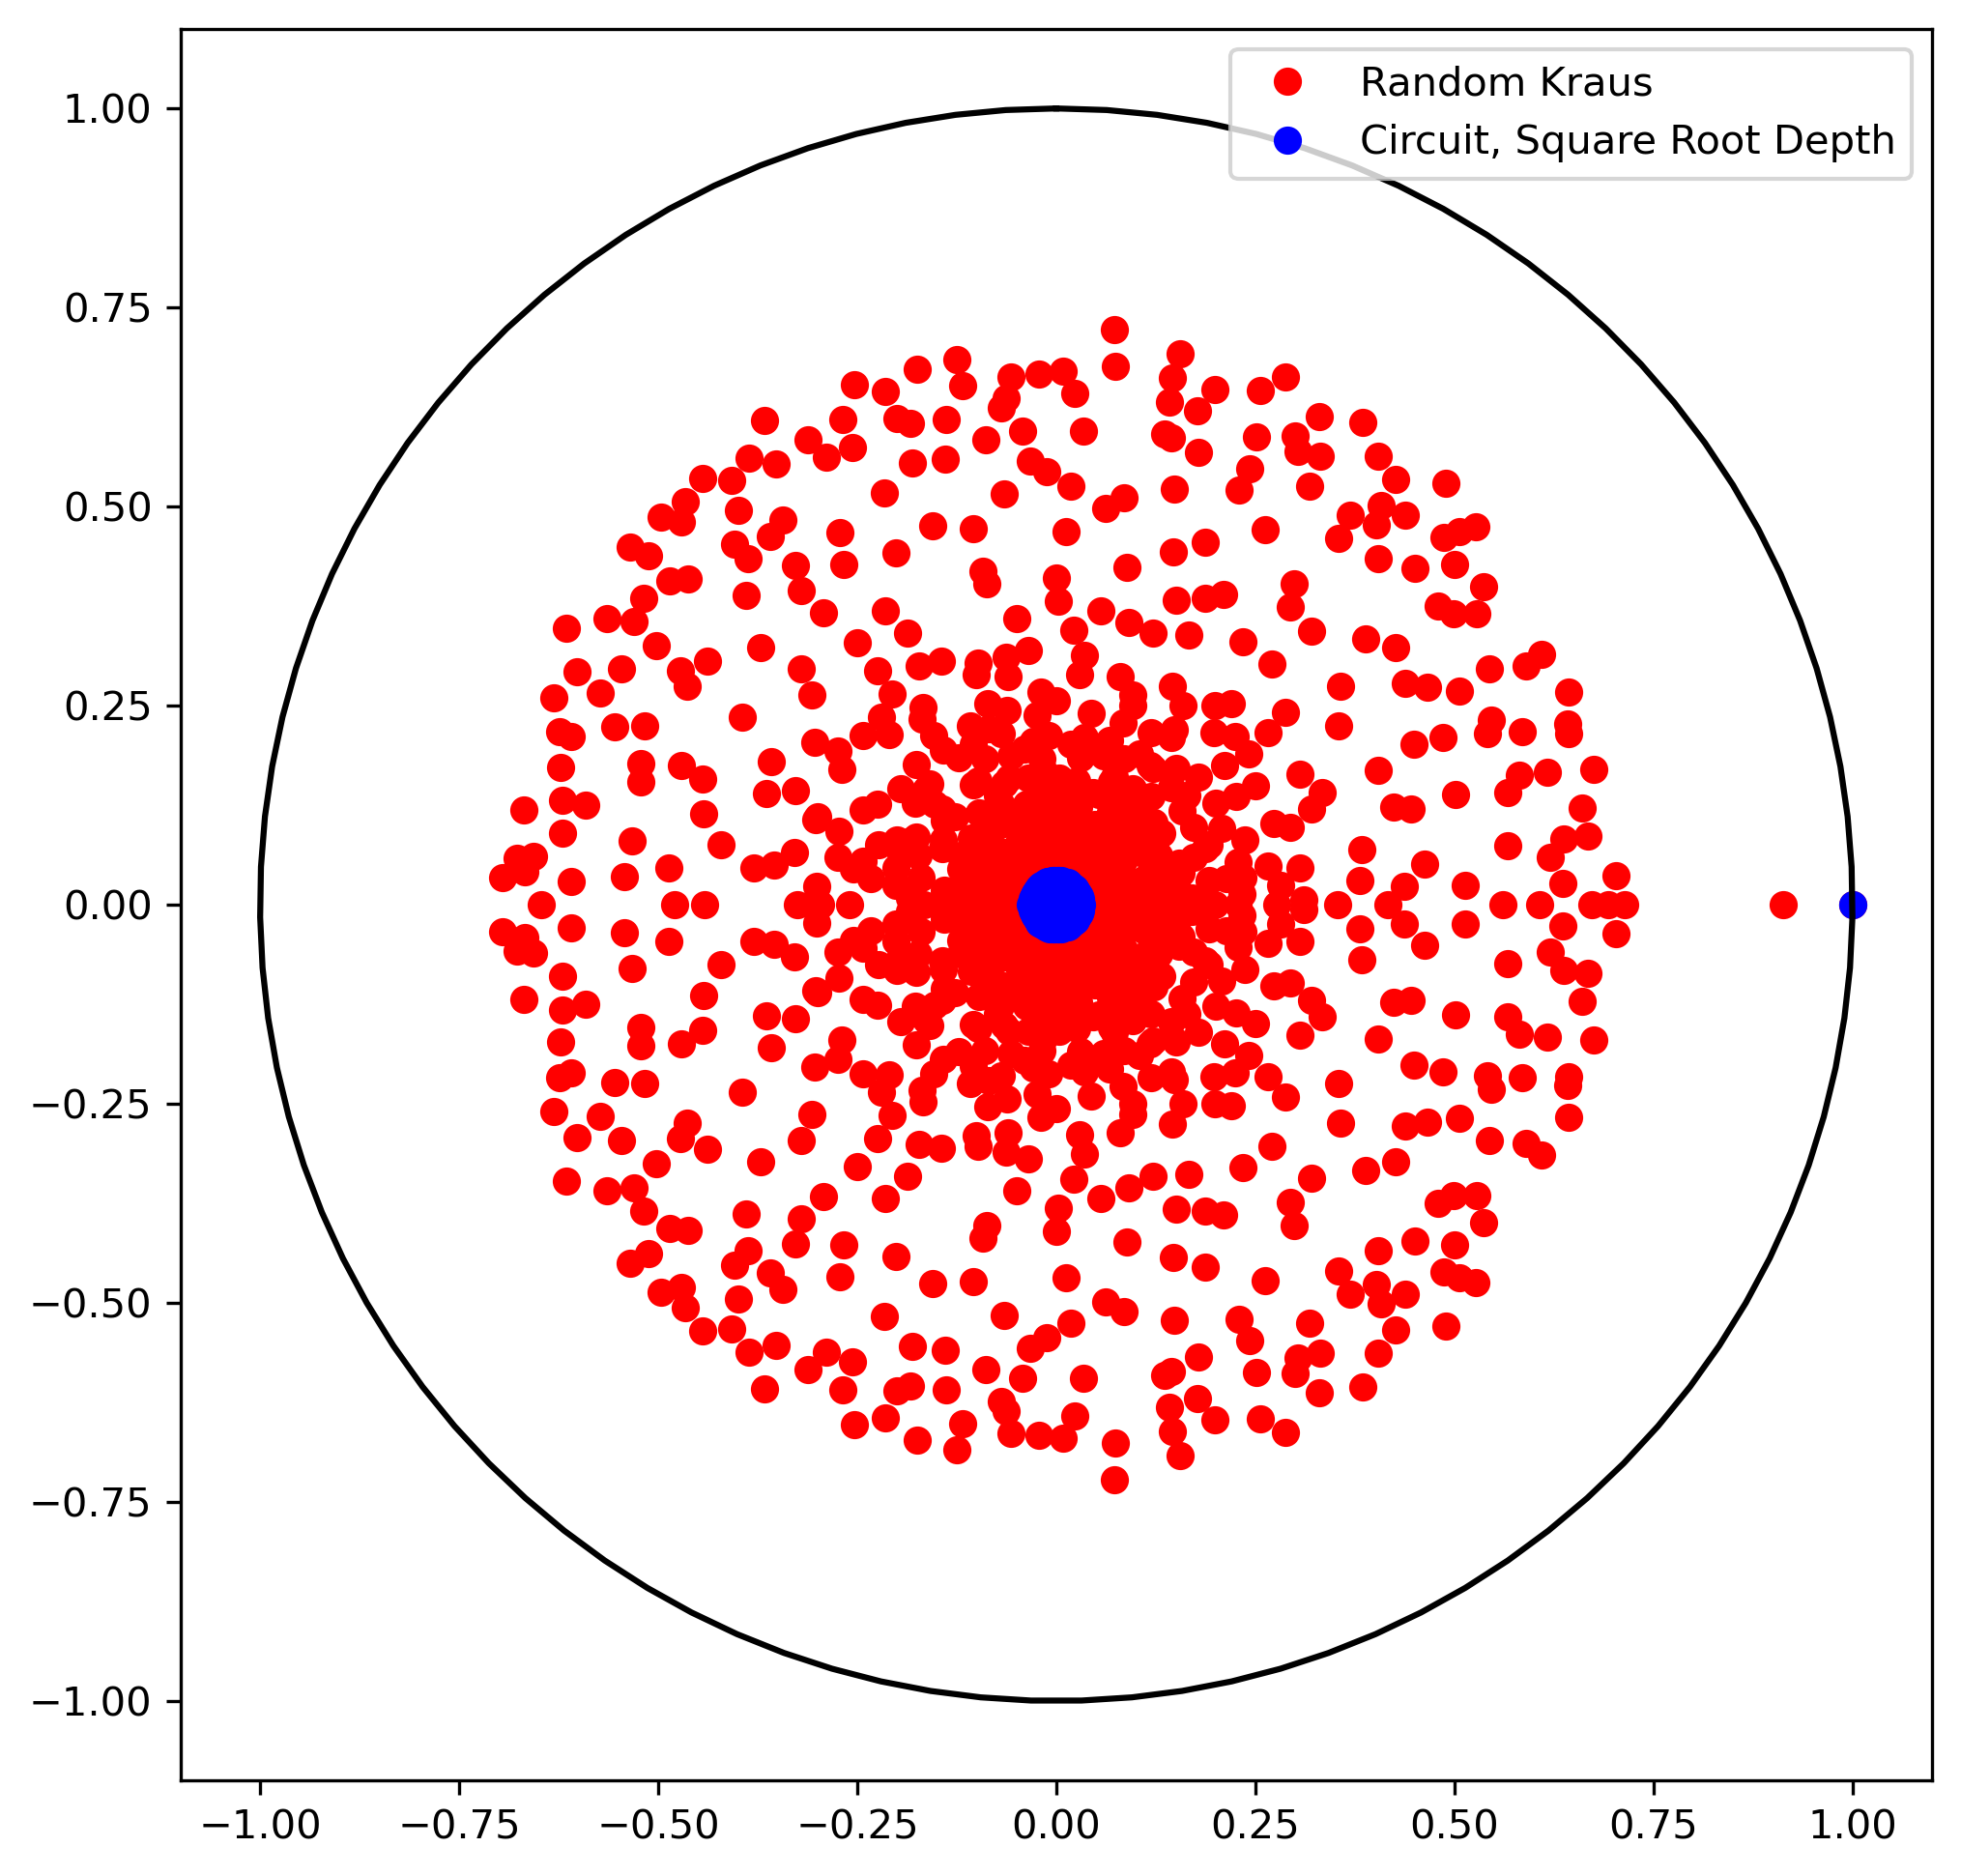

In [23]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))


random.seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
for i in tqdm(range(1)):
    kraus_map = KrausMap(d=d, rank=rank)
    choi_map = maps_to_choi([kraus_map])
    spectrum1 = choi_spectrum(choi_map)

    U = generate_random_variational_unitary(d, rank, depth=round(np.sqrt(n_eff)), verbose=True)
    kraus_map.generate_map(U=U)
    choi_map = maps_to_choi([kraus_map])
    spectrum2 = choi_spectrum(choi_map)

    plt.plot(*spectrum2, "ro")
    plt.plot(*spectrum1, "bo")

plt.legend(["Random Kraus", "Circuit, Square Root Depth"])
plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fiveQubit_squareRootDepth.pdf")
plt.show()